<a href="https://colab.research.google.com/github/jiin-son/nba/blob/main/NBA_Machine_Learning_(xgboost)_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.3f}'.format
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score

In [2]:
!pip install xgboost
import xgboost as xgb

In [3]:
!pip install optuna
import optuna

In [4]:
!pip install shap==0.47.1
# import shap

  Using cached shap-0.47.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (25 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 972.6/972.6 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.46.0
    Uninstalling shap-0.46.0:
      Successfully uninstalled shap-0.46.0


In [5]:
import shap

In [6]:
from google.colab import files
uploaded = files.upload()

Saving final_df.csv to final_df (1).csv


In [7]:
final_df = pd.read_csv('final_df.csv')

In [8]:
# Function to convert time to total minutes
def time_to_minutes(time_str):
    try:
        minutes, seconds = time_str.split(':')
        minutes = float(minutes)  # Handle decimal minutes
        seconds = int(seconds)  # Handle seconds
        return minutes + seconds / 60
    except ValueError:
        return None  # Handle invalid formats gracefully

# Apply the function
final_df['TOTAL_MIN'] = final_df['MIN'].apply(time_to_minutes)

In [9]:
# remove records that MIN is less than 1 minute
final_df = final_df[final_df['TOTAL_MIN'] >= 1]

In [10]:
from google.colab import files
uploaded = files.upload()

Saving all_teams_gamelog_df.csv to all_teams_gamelog_df (1).csv


In [11]:
teams_gamelog_df = pd.read_csv('all_teams_gamelog_df.csv')

In [12]:
# create a column that shows win streak for the previous  GAME_DATE (one game lag) for each Team_ID and Game_ID

# Sort the DataFrame by Team_ID and GAME_DATE
df = teams_gamelog_df.sort_values(['Team_ID', 'GAME_DATE'])

# Group by Team_ID
grouped = df.groupby('Team_ID')

# Function to calculate win streaks
def calculate_win_streak(group):
    win_streak = []
    current_streak = 0
    for i, row in group.iterrows():
      if row['WL'] == 'W':
        current_streak += 1
      else:
        current_streak = 0
      win_streak.append(current_streak)
    group['win_streak'] = win_streak
    return group

# Apply the function to each group
df = grouped.apply(calculate_win_streak).reset_index(drop=True)

# Shift the win streak column to create a one-game lag
df['previous_game_win_streak'] = df.groupby('Team_ID')['win_streak'].shift(1)

# Fill NaN values with 0 (for the first game of each team)
df['previous_game_win_streak'] = df['previous_game_win_streak'].fillna(0)


<ipython-input-12-4c3124eb2296>:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = grouped.apply(calculate_win_streak).reset_index(drop=True)


In [13]:
df

Team_ID   Game_ID     GAME_DATE      MATCHUP WL      W      L  W_PCT  \
0     1610612737  22400315  DEC 02, 2024  ATL vs. NOP  W 11.000 11.000  0.500   
1     1610612737  22400323  DEC 04, 2024    ATL @ MIL  W 12.000 11.000  0.522   
2     1610612737  22400334  DEC 06, 2024  ATL vs. LAL  W 13.000 11.000  0.542   
3     1610612737  22400350  DEC 08, 2024  ATL vs. DEN  L 13.000 12.000  0.520   
4     1610612737  22401202  DEC 11, 2024    ATL @ NYK  W 14.000 12.000  0.538   
...          ...       ...           ...          ... ..    ...    ...    ...   
1032  1610612766  22400300  NOV 30, 2024  CHA vs. ATL  L  6.000 14.000  0.300   
1033  1610612766  22400068  OCT 23, 2024    CHA @ HOU  W  1.000  0.000  1.000   
1034  1610612766  22400079  OCT 25, 2024    CHA @ ATL  L  1.000  1.000  0.500   
1035  1610612766  22400088  OCT 26, 2024  CHA vs. MIA  L  1.000  2.000  0.333   
1036  1610612766  22400117  OCT 30, 2024  CHA vs. TOR  W  2.000  2.000  0.500   

      MIN  FGM  FGA  FG_PCT  FG3M  FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  \
0     240   49   96   0.510    10    38    0.263   16   20   0.800    11   
1     240   45  102   0.441     9    32    0.281   20   22   0.909    15   
2     265   50  100   0.500    17    40    0.425   17   22   0.773    11   
3     240   41  101   0.406     9    40    0.225   20   27   0.741    19   
4     240   43  104   0.413     9    31    0.290   13   20   0.650    22   
...   ...  ...  ...     ...   ...   ...      ...  ...  ...     ...   ...   
1032  240   35   94   0.372    18    48    0.375   16   19   0.842    18   
1033  240   38   85   0.447    15    39    0.385   19   24   0.792    15   
1034  240   37   96   0.385    21    51    0.412   25   31   0.806    22   
1035  240   39   89   0.438    13    41    0.317   15   21   0.714    15   
1036  240   49   94   0.521    20    45    0.444   20   25   0.800    14   

      DREB  REB  AST  STL  BLK  TOV  PF  PTS          TEAM_NAME  win_streak  \
0       40   51   30   12    4   18  15  124      Atlanta Hawks           1   
1       39   54   29   16    3   11  25  119      Atlanta Hawks           2   
2       37   48   40   10    5   17  24  134      Atlanta Hawks           3   
3       26   45   26   12    2   12  22  111      Atlanta Hawks           0   
4       36   58   27    5    7   10  13  108      Atlanta Hawks           1   
...    ...  ...  ...  ...  ...  ...  ..  ...                ...         ...   
1032    27   45   23   13    6   14  23  104  Charlotte Hornets           0   
1033    41   56   20    6   10   16  21  110  Charlotte Hornets           1   
1034    31   53   22    7    4   17  28  120  Charlotte Hornets           0   
1035    31   46   20    6    5   17  24  106  Charlotte Hornets           0   
1036    24   38   31    9    8   15  24  138  Charlotte Hornets           1   

      previous_game_win_streak  
0                        0.000  
1                        1.000  
2                        2.000  
3                        3.000  
4                        0.000  
...                        ...  
1032                     0.000  
1033                     0.000  
1034                     1.000  
1035                     0.000  
1036                     0.000  

[1037 rows x 30 columns]

In [14]:
# prompt: convert all the variable name of df to upper case

# Rename columns to uppercase
df = df.rename(columns=str.upper)


In [15]:
# prompt: left join df to the final_df table

# Merge the two dataframes
final_df = pd.merge(final_df, df[['TEAM_ID', 'GAME_ID', 'PREVIOUS_GAME_WIN_STREAK']], on=['TEAM_ID', 'GAME_ID'], how='left')

# Display the updated DataFrame
final_df


GAME_ID     TEAM_ID TEAM_ABBREVIATION TEAM_CITY  PLAYER_ID  \
0     22400487  1610612738               BOS    Boston    1627759   
1     22400487  1610612738               BOS    Boston    1628369   
2     22400487  1610612738               BOS    Boston     204001   
3     22400487  1610612738               BOS    Boston    1628401   
4     22400487  1610612738               BOS    Boston     201950   
...        ...         ...               ...       ...        ...   
9542  22400061  1610612738               BOS    Boston    1630202   
9543  22400061  1610612738               BOS    Boston    1630573   
9544  22400061  1610612738               BOS    Boston    1630214   
9545  22400061  1610612738               BOS    Boston    1641775   
9546  22400061  1610612738               BOS    Boston    1629674   

             PLAYER_NAME  NICKNAME START_POSITION  COMMENT           MIN  \
0           Jaylen Brown    Jaylen              F      NaN  39.000000:37   
1           Jayson Tatum    Jayson              F      NaN  38.000000:52   
2     Kristaps Porziņģis  Kristaps              C      NaN  29.000000:19   
3          Derrick White   Derrick              G      NaN  37.000000:16   
4           Jrue Holiday      Jrue              G      NaN  33.000000:49   
...                  ...       ...            ...      ...           ...   
9542    Payton Pritchard    Payton            NaN      NaN  24.000000:58   
9543          Sam Hauser       Sam            NaN      NaN  24.000000:10   
9544      Xavier Tillman    Xavier            NaN      NaN  17.000000:42   
9545        Jordan Walsh    Jordan            NaN      NaN   6.000000:05   
9546       Neemias Queta   Neemias            NaN      NaN   4.000000:20   

       FGM    FGA  FG_PCT  FG3M   FG3A  FG3_PCT    FTM    FTA  FT_PCT  OREB  \
0    8.000 19.000   0.421 1.000  6.000    0.167  4.000  4.000   1.000 0.000   
1    7.000 17.000   0.412 2.000  6.000    0.333 10.000 12.000   0.833 1.000   
2    6.000 12.000   0.500 1.000  6.000    0.167  6.000  6.000   1.000 4.000   
3    4.000 13.000   0.308 2.000 11.000    0.182  1.000  2.000   0.500 0.000   
4    1.000  6.000   0.167 0.000  4.000    0.000  0.000  0.000   0.000 3.000   
...    ...    ...     ...   ...    ...      ...    ...    ...     ...   ...   
9542 1.000 10.000   0.100 1.000  9.000    0.111  0.000  0.000   0.000 1.000   
9543 4.000 10.000   0.400 2.000  7.000    0.286  0.000  0.000   0.000 1.000   
9544 1.000  6.000   0.167 0.000  3.000    0.000  0.000  0.000   0.000 3.000   
9545 0.000  1.000   0.000 0.000  1.000    0.000  0.000  0.000   0.000 0.000   
9546 0.000  0.000   0.000 0.000  0.000    0.000  0.000  0.000   0.000 0.000   

      DREB    REB   AST   STL   BLK    TO    PF    PTS  PLUS_MINUS  \
0    3.000  3.000 3.000 1.000 1.000 3.000 2.000 21.000      -7.000   
1    9.000 10.000 1.000 2.000 0.000 2.000 1.000 26.000     -12.000   
2    5.000  9.000 1.000 1.000 0.000 4.000 5.000 19.000     -17.000   
3    4.000  4.000 4.000 1.000 3.000 3.000 1.000 11.000      -8.000   
4    5.000  8.000 6.000 0.000 0.000 2.000 4.000  2.000     -11.000   
...    ...    ...   ...   ...   ...   ...   ...    ...         ...   
9542 3.000  4.000 4.000 0.000 0.000 1.000 2.000  3.000       7.000   
9543 4.000  5.000 1.000 0.000 0.000 0.000 2.000 10.000       6.000   
9544 4.000  7.000 2.000 0.000 0.000 0.000 1.000  2.000      -3.000   
9545 0.000  0.000 1.000 0.000 0.000 0.000 0.000  0.000      -9.000   
9546 0.000  0.000 0.000 0.000 0.000 0.000 1.000  0.000      -3.000   

            POSITION HEIGHT  WEIGHT  YEARS_IN_LEAGUE   GAME_DATE  GAME_MIN  \
0      Guard-Forward    6-6 223.000            9.000  2025-01-05   240.000   
1      Forward-Guard    6-8 210.000            8.000  2025-01-05   240.000   
2     Forward-Center    7-2 240.000           10.000  2025-01-05   240.000   
3              Guard    6-4 190.000            8.000  2025-01-05   240.000   
4              Guard    6-4 205.000           16.000  2025-01-05   240.000   
...    

In [16]:
# Final Dataset
prep_df = final_df[[
    # identifier
    'GAME_ID', 'PLAYER_ID',

    # game
    'HOME', 'OVERTIME', 'REST_DAYS', 'PREVIOUS_GAME_WIN_STREAK',

    # boxscore
    'FG_PCT', 'FT_PCT',
    'REB', 'AST', 'STL', 'BLK', 'TO', 'PF',

    # player metadata
    'Height_in_Inches', 'YEARS_IN_LEAGUE',

    # last season data
    'FG_PCT_LAST_SEASON',
    'FT_PCT_LAST_SEASON',
    'REB_LAST_SEASON',
    'AST_LAST_SEASON',
    'STL_LAST_SEASON',
    'BLK_LAST_SEASON',
    'TOV_LAST_SEASON',
    'PF_LAST_SEASON',
    'TRADED_LAST_SEASON',

    # this season data
    'PLAYER_AGE',
    'TRADED_THIS_SEASON',
    # 'POS_G', 'POS_F', 'POS_C', 'POS_FC', 'POS_GF', 'POS_CF', 'POS_FG',
    'TEAM_GSW', 'TEAM_OKC', 'TEAM_CHI', 'TEAM_MEM', 'TEAM_ORL', 'TEAM_SAS',
    'TEAM_DAL', 'TEAM_TOR', 'TEAM_LAC', 'TEAM_PHI', 'TEAM_SAC', 'TEAM_BOS',
    'TEAM_IND', 'TEAM_DET', 'TEAM_MIL', 'TEAM_CLE', 'TEAM_WAS', 'TEAM_CHA',
    'TEAM_HOU', 'TEAM_DEN', 'TEAM_PHX', 'TEAM_MIA', 'TEAM_UTA', 'TEAM_LAL',
    'TEAM_POR', 'TEAM_MIN', 'TEAM_NYK', 'TEAM_BKN', 'TEAM_ATL', 'TEAM_NOP',
    # potential opportunity to use these team segment to have tailored strategy to win the game

    # response variable
    'W']]
prep_df

GAME_ID  PLAYER_ID  HOME  OVERTIME  REST_DAYS  \
0     22400487    1627759 0.000     0.000      2.000   
1     22400487    1628369 0.000     0.000      2.000   
2     22400487     204001 0.000     0.000      2.000   
3     22400487    1628401 0.000     0.000      2.000   
4     22400487     201950 0.000     0.000      2.000   
...        ...        ...   ...       ...        ...   
9542  22400061    1630202 1.000     0.000      0.000   
9543  22400061    1630573 1.000     0.000      0.000   
9544  22400061    1630214 1.000     0.000      0.000   
9545  22400061    1641775 1.000     0.000      0.000   
9546  22400061    1629674 1.000     0.000      0.000   

      PREVIOUS_GAME_WIN_STREAK  FG_PCT  FT_PCT    REB   AST   STL   BLK    TO  \
0                        3.000   0.421   1.000  3.000 3.000 1.000 1.000 3.000   
1                        3.000   0.412   0.833 10.000 1.000 2.000 0.000 2.000   
2                        3.000   0.500   1.000  9.000 1.000 1.000 0.000 4.000   
3                        3.000   0.308   0.500  4.000 4.000 1.000 3.000 3.000   
4                        3.000   0.167   0.000  8.000 6.000 0.000 0.000 2.000   
...                        ...     ...     ...    ...   ...   ...   ...   ...   
9542                     7.000   0.100   0.000  4.000 4.000 0.000 0.000 1.000   
9543                     7.000   0.400   0.000  5.000 1.000 0.000 0.000 0.000   
9544                     7.000   0.167   0.000  7.000 2.000 0.000 0.000 0.000   
9545                     7.000   0.000   0.000  0.000 1.000 0.000 0.000 0.000   
9546                     7.000   0.000   0.000  0.000 0.000 0.000 0.000 0.000   

        PF  Height_in_Inches  YEARS_IN_LEAGUE  FG_PCT_LAST_SEASON  \
0    2.000                78            9.000               0.499   
1    1.000                80            8.000               0.471   
2    5.000                86           10.000               0.516   
3    1.000                76            8.000               0.461   
4    4.000                76           16.000               0.480   
...    ...               ...              ...                 ...   
9542 2.000                73            5.000               0.468   
9543 2.000                79            4.000               0.446   
9544 1.000                79            5.000               0.434   
9545 0.000                78            2.000               0.400   
9546 1.000                84            4.000               0.644   

      FT_PCT_LAST_SEASON  REB_LAST_SEASON  AST_LAST_SEASON  STL_LAST_SEASON  \
0                  0.703          387.000          249.000           83.000   
1                  0.833          601.000          364.000           75.000   
2                  0.858          409.000          115.000           42.000   
3                  0.901          310.000          377.000           74.000   
4                  0.833          373.000          333.000           61.000   
...                  ...              ...              ...              ...   
9542               0.821          265.000          281.000           39.000   
9543               0.895          276.000           82.000           40.000   
9544               0.440          211.000           77.000           51.000   
9545               0.500           20.000            5.000            5.000   
9546               0.714          122.000           20.000           13.000   

      BLK_LAST_SEASON  TOV_LAST_SEASON  PF_LAST_SEASON  TRADED_LAST_SEASON  \
0              37.000          166.000         185.000               0.000   
1              43.000          188.000         145.000               0.000   
2             111.000           89.000         156.000               0.000   
3              87.000          112.000         152.000               0.000   
4              53.000          124.000         108.000               0.000   
...               ...              ...             ...                 ...   
9542            6.000           61.00

In [17]:
df = prep_df

In [18]:
# prompt: do the one hot coding for game_id and player_id

# One-hot encode 'GAME_ID' and 'PLAYER_ID'
df = pd.get_dummies(df, columns=['GAME_ID', 'PLAYER_ID'], drop_first=True, dtype='int')


In [19]:
df

HOME  OVERTIME  REST_DAYS  PREVIOUS_GAME_WIN_STREAK  FG_PCT  FT_PCT  \
0    0.000     0.000      2.000                     3.000   0.421   1.000   
1    0.000     0.000      2.000                     3.000   0.412   0.833   
2    0.000     0.000      2.000                     3.000   0.500   1.000   
3    0.000     0.000      2.000                     3.000   0.308   0.500   
4    0.000     0.000      2.000                     3.000   0.167   0.000   
...    ...       ...        ...                       ...     ...     ...   
9542 1.000     0.000      0.000                     7.000   0.100   0.000   
9543 1.000     0.000      0.000                     7.000   0.400   0.000   
9544 1.000     0.000      0.000                     7.000   0.167   0.000   
9545 1.000     0.000      0.000                     7.000   0.000   0.000   
9546 1.000     0.000      0.000                     7.000   0.000   0.000   

        REB   AST   STL   BLK    TO    PF  Height_in_Inches  YEARS_IN_LEAGUE  \
0     3.000 3.000 1.000 1.000 3.000 2.000                78            9.000   
1    10.000 1.000 2.000 0.000 2.000 1.000                80            8.000   
2     9.000 1.000 1.000 0.000 4.000 5.000                86           10.000   
3     4.000 4.000 1.000 3.000 3.000 1.000                76            8.000   
4     8.000 6.000 0.000 0.000 2.000 4.000                76           16.000   
...     ...   ...   ...   ...   ...   ...               ...              ...   
9542  4.000 4.000 0.000 0.000 1.000 2.000                73            5.000   
9543  5.000 1.000 0.000 0.000 0.000 2.000                79            4.000   
9544  7.000 2.000 0.000 0.000 0.000 1.000                79            5.000   
9545  0.000 1.000 0.000 0.000 0.000 0.000                78            2.000   
9546  0.000 0.000 0.000 0.000 0.000 1.000                84            4.000   

      FG_PCT_LAST_SEASON  FT_PCT_LAST_SEASON  REB_LAST_SEASON  \
0                  0.499               0.703          387.000   
1                  0.471               0.833          601.000   
2                  0.516               0.858          409.000   
3                  0.461               0.901          310.000   
4                  0.480               0.833          373.000   
...                  ...                 ...              ...   
9542               0.468               0.821          265.000   
9543               0.446               0.895          276.000   
9544               0.434               0.440          211.000   
9545               0.400               0.500           20.000   
9546               0.644               0.714          122.000   

      AST_LAST_SEASON  STL_LAST_SEASON  BLK_LAST_SEASON  TOV_LAST_SEASON  \
0             249.000           83.000           37.000          166.000   
1             364.000           75.000           43.000          188.000   
2             115.000           42.000          111.000           89.000   
3             377.000           74.000           87.000          112.000   
4             333.000           61.000           53.000          124.000   
...               ...              ...              ...              ...   
9542          281.000           39.000            6.000           61.000   
9543           82.000           40.000           25.000           32.000   
9544           77.000           51.000           44.000           34.000   
9545            5.000            5.000            1.000            3.000   
9546           20.000           13.000           21.000           13.000   

      PF_LAST_SEASON  TRADED_LAST_SEASON  PLAYER_AGE  TRADED_THIS_SEASON  \
0            185.000               0.000      28.000                   0   
1            145.000               0.000      26.000                   0   
2            156.000               0.000      29.000                   0   
3            152.000               0.000      30.000                   0   
4            108.000               0.000      

In [20]:
import random
import hashlib

def md5_hash(input_string):
  """Generates an MD5 hash from a given string.
  Args:
    input_string: The string to hash.
  Returns:
    The MD5 hash as a hexadecimal string.
  """
  md5_hasher = hashlib.md5()
  md5_hasher.update(input_string.encode('utf-8'))
  return md5_hasher.hexdigest()

# Example usage
input_string = "NBA"
hashed_value = md5_hash(input_string)
print(f"The MD5 hash of '{input_string}' is: {hashed_value}")

# Convert the hexadecimal hash to an integer
try:
    number = int(hashed_value, 16)
    print(f"The integer representation of the hash is: {number}")
except ValueError:
    print("Invalid hexadecimal string")

# Set the seed value
random.seed(number)

print(f"Initial seed number: {number}")

# Generate a list of 10 random numbers
random.seed(number)
a = 0
b = 2**31-1
random_numbers = [random.randint(a, b) for _ in range(10)]

# Print the list
print("Seed", random_numbers)

The MD5 hash of 'NBA' is: 52b6d6fc82db6aef110362f4755a1fe8
The integer representation of the hash is: 109946054124266886270703940407869972456
Initial seed number: 109946054124266886270703940407869972456
Seed [1578879816, 1978497697, 1190903919, 1878057853, 1288653849, 873208946, 343223680, 1954458820, 1609495891, 882467736]


In [21]:
# as a coach, understand the other teams to predict the NYK success
# basketball is a team sports, need to understand on opponents
X_train = df[(df['TEAM_NYK'] != 1 )|( df['TEAM_BOS'] != 1 )].drop(['W'], axis = 1)
X_val  = df[df['TEAM_BOS'] == 1].drop(['W'], axis = 1)
X_test  = df[df['TEAM_NYK'] == 1].drop(['W'], axis = 1)

y_train = df[(df['TEAM_NYK'] != 1 )|( df['TEAM_BOS'] != 1 )]['W']
y_val  = df[df['TEAM_BOS'] == 1]['W']
y_test  = df[df['TEAM_NYK'] == 1]['W']

In [22]:
X_train = X_train.drop(['TEAM_GSW', 'TEAM_OKC', 'TEAM_CHI', 'TEAM_MEM', 'TEAM_ORL', 'TEAM_SAS',
                        'TEAM_DAL', 'TEAM_TOR', 'TEAM_LAC', 'TEAM_PHI', 'TEAM_SAC', 'TEAM_BOS',
                        'TEAM_IND', 'TEAM_DET', 'TEAM_MIL', 'TEAM_CLE', 'TEAM_WAS', 'TEAM_CHA',
                        'TEAM_HOU', 'TEAM_DEN', 'TEAM_PHX', 'TEAM_MIA', 'TEAM_UTA', 'TEAM_LAL',
                        'TEAM_POR', 'TEAM_MIN', 'TEAM_NYK', 'TEAM_BKN', 'TEAM_ATL', 'TEAM_NOP'], axis = 1)
X_val  = X_val.drop(['TEAM_GSW', 'TEAM_OKC', 'TEAM_CHI', 'TEAM_MEM', 'TEAM_ORL', 'TEAM_SAS',
                      'TEAM_DAL', 'TEAM_TOR', 'TEAM_LAC', 'TEAM_PHI', 'TEAM_SAC', 'TEAM_BOS',
                      'TEAM_IND', 'TEAM_DET', 'TEAM_MIL', 'TEAM_CLE', 'TEAM_WAS', 'TEAM_CHA',
                      'TEAM_HOU', 'TEAM_DEN', 'TEAM_PHX', 'TEAM_MIA', 'TEAM_UTA', 'TEAM_LAL',
                      'TEAM_POR', 'TEAM_MIN', 'TEAM_NYK', 'TEAM_BKN', 'TEAM_ATL', 'TEAM_NOP'], axis = 1 )
X_test  = X_test.drop(['TEAM_GSW', 'TEAM_OKC', 'TEAM_CHI', 'TEAM_MEM', 'TEAM_ORL', 'TEAM_SAS',
                      'TEAM_DAL', 'TEAM_TOR', 'TEAM_LAC', 'TEAM_PHI', 'TEAM_SAC', 'TEAM_BOS',
                      'TEAM_IND', 'TEAM_DET', 'TEAM_MIL', 'TEAM_CLE', 'TEAM_WAS', 'TEAM_CHA',
                      'TEAM_HOU', 'TEAM_DEN', 'TEAM_PHX', 'TEAM_MIA', 'TEAM_UTA', 'TEAM_LAL',
                      'TEAM_POR', 'TEAM_MIN', 'TEAM_NYK', 'TEAM_BKN', 'TEAM_ATL', 'TEAM_NOP'], axis = 1 )
X = df.drop(['W','TEAM_GSW', 'TEAM_OKC', 'TEAM_CHI', 'TEAM_MEM', 'TEAM_ORL', 'TEAM_SAS',
            'TEAM_DAL', 'TEAM_TOR', 'TEAM_LAC', 'TEAM_PHI', 'TEAM_SAC', 'TEAM_BOS',
            'TEAM_IND', 'TEAM_DET', 'TEAM_MIL', 'TEAM_CLE', 'TEAM_WAS', 'TEAM_CHA',
            'TEAM_HOU', 'TEAM_DEN', 'TEAM_PHX', 'TEAM_MIA', 'TEAM_UTA', 'TEAM_LAL',
            'TEAM_POR', 'TEAM_MIN', 'TEAM_NYK', 'TEAM_BKN', 'TEAM_ATL', 'TEAM_NOP'], axis = 1)
y = df['W']

In [23]:
# prompt: run base xgboost model for five seeds for split with X and y dataset
# X_test = X_val
# y_test = y_val
results = []
for seed in random_numbers[:5]:
  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

  model = xgb.XGBClassifier(random_state = seed)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

   # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  f1_negative = f1_score(y_test, y_pred, pos_label = 0)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)

  results.append({
      'seed': seed,
      'accuracy': accuracy,
      'f1': f1,
      'f1_negative': f1_negative,
      'precision': precision,
      'recall': recall,
      'auc': auc
  })

# Print the results
for result in results:
  print(f"Seed: {result['seed']}, Accuracy: {result['accuracy']:.4f}, F1: {result['f1']:.4f}, F1 Negative: {result['f1_negative']:.4f}, Precision: {result['precision']:.4f}, Recall: {result['recall']:.4f}, AUC: {result['auc']:.4f}")


Seed: 1578879816, Accuracy: 0.8065, F1: 0.8653, F1 Negative: 0.6562, Precision: 0.8281, Recall: 0.9060, AUC: 0.7474
Seed: 1978497697, Accuracy: 0.8065, F1: 0.8653, F1 Negative: 0.6562, Precision: 0.8281, Recall: 0.9060, AUC: 0.7474
Seed: 1190903919, Accuracy: 0.8065, F1: 0.8653, F1 Negative: 0.6562, Precision: 0.8281, Recall: 0.9060, AUC: 0.7474
Seed: 1878057853, Accuracy: 0.8065, F1: 0.8653, F1 Negative: 0.6562, Precision: 0.8281, Recall: 0.9060, AUC: 0.7474
Seed: 1288653849, Accuracy: 0.8065, F1: 0.8653, F1 Negative: 0.6562, Precision: 0.8281, Recall: 0.9060, AUC: 0.7474


In [ ]:
confusion_matrix(y_test, y_pred)

array([[ 44,  38],
       [ 17, 227]])

In [ ]:
confusion_matrix(y_test, y_pred)

array([[ 63,  44],
       [ 22, 212]])

In [ ]:
# prompt: use results dataframe to compute mean, median, and standard deivation across the 5 seeds for each metrics (accuracy, f1, etc) in long format

results_df = pd.DataFrame(results)

# Melt the DataFrame to long format
results_long = pd.melt(results_df, id_vars=['seed'], var_name='metric', value_name='value')

# Group by metric and calculate mean, median, and standard deviation
summary_stats = results_long.groupby('metric')['value'].agg(['mean', 'median', 'std'])

print(results_df)
print(summary_stats)


         seed  accuracy    f1  f1_negative  precision  recall   auc
0  1578879816     0.831 0.892        0.615      0.857   0.930 0.733
1  1978497697     0.831 0.892        0.615      0.857   0.930 0.733
2  1190903919     0.831 0.892        0.615      0.857   0.930 0.733
3  1878057853     0.831 0.892        0.615      0.857   0.930 0.733
4  1288653849     0.831 0.892        0.615      0.857   0.930 0.733
             mean  median   std
metric                         
accuracy    0.831   0.831 0.000
auc         0.733   0.733 0.000
f1          0.892   0.892 0.000
f1_negative 0.615   0.615 0.000
precision   0.857   0.857 0.000
recall      0.930   0.930 0.000


In [ ]:
num_negative = y_val[y_val == 0].shape[0]
num_positive = y_val[y_val == 1].shape[0]

scale_pos_weight = num_negative / num_positive
print(f"scale_pos_weight: {scale_pos_weight:.4f}")

scale_pos_weight: 0.3361


In [24]:
all_shap_values = []
all_feature_values = []
all_selected_features = []
feature_selection_counts = {}

In [ ]:
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

seed = random_numbers[0]

def objective(trial):
    # Define the parameter search space for XGBoost
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        'scale_pos_weight': 0.7,
        'random_state': seed
    }

    # Part 1: Feature Selection with XGBoost
    selection_model = XGBClassifier(**param)
    selection_model.fit(X_train, y_train)

    selector = SelectFromModel(selection_model, prefit=True, threshold='mean', max_features = 20)
    selected_indices = selector.get_support()
    selected_features = X_train.columns[selected_indices].tolist()

    trial.set_user_attr('selected_features', selected_features)

    X_train_selected = X_train.iloc[:, selected_indices]
    X_val_selected = X_val.iloc[:, selected_indices]

    # Part 2: Train final XGBoost model on selected features
    dtrain = xgb.DMatrix(X_train_selected, label=y_train)
    dval = xgb.DMatrix(X_val_selected, label=y_val)

    xgb_params = {
        "num_parallel_tree": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "scale_pos_weight": 0.7,
        "random_state": seed
    }

    model = xgb.train(xgb_params, dtrain)
    preds = model.predict(dval)
    pred_labels = np.rint(preds)

    f1_neg = f1_score(y_val, pred_labels, pos_label = 0)

    return f1_neg


# Create study object
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed))

# Run optimization process
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Print best trial and best hyperparameters
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)
print("Best features:", study.best_trial.user_attrs['selected_features'])




[I 2025-03-02 22:54:51,629] A new study created in memory with name: no-name-817c0e56-d77e-49b0-9d98-91d2a59202fe


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-03-02 22:55:09,268] Trial 0 finished with value: 0.4019607843137255 and parameters: {'n_estimators': 186, 'max_depth': 65, 'learning_rate': 0.0018741207669069687, 'subsample': 0.7060650715366277, 'colsample_bytree': 0.7490482995951815, 'min_child_weight': 7, 'gamma': 0.03540972425977073, 'alpha': 6.513137628940538e-05, 'lambda': 6.073221485945018e-06}. Best is trial 0 with value: 0.4019607843137255.
[I 2025-03-02 22:55:20,723] Trial 1 finished with value: 0.4019607843137255 and parameters: {'n_estimators': 151, 'max_depth': 35, 'learning_rate': 0.0013377490469517084, 'subsample': 0.5630606761606125, 'colsample_bytree': 0.5694836586658301, 'min_child_weight': 10, 'gamma': 7.325690400664528e-05, 'alpha': 0.7536212054856437, 'lambda': 3.971689356156751e-05}. Best is trial 0 with value: 0.4019607843137255.
[I 2025-03-02 22:55:38,619] Trial 2 finished with value: 0.4019607843137255 and parameters: {'n_estimators': 295, 'max_depth': 64, 'learning_rate': 0.001290409372874329, 'subsamp

In [ ]:
# Store the best features and how often each feature is selected
best_features = study.best_trial.user_attrs['selected_features']
# Collect the best features
all_selected_features.append(best_features)
# Count how often each feature is selected
for feature in best_features:
    feature_selection_counts[feature] = feature_selection_counts.get(feature, 0) + 1

# Step 4: Train Final Model on Train + Validation Data with Best Features
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

X_train_val_selected = X_train_val[best_features]
X_test_selected = X_test[best_features]

dtrain_final = xgb.DMatrix(X_train_val_selected, label=y_train_val)
dtest_final = xgb.DMatrix(X_test_selected, label=y_test)

best_xgb_params = study.best_params
best_xgb_params['random_state'] = seed
best_xgb_params['num_parallel_tree'] = study.best_params['n_estimators']
del best_xgb_params['n_estimators']
best_xgb_params['scale_pos_weight'] = 0.7
final_model = xgb.train(best_xgb_params, dtrain_final)

# Step 5: Evaluate on Test Set
test_preds = final_model.predict(dtest_final)
test_pred_labels = np.rint(test_preds)

print(f"Accuracy: {accuracy_score(y_test, test_pred_labels):.3f}")
print(f"F1 Score: {f1_score(y_test, test_pred_labels):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, test_pred_labels, pos_label = 0):.3f}")
print(f"Specificity: {precision_score(y_test, test_pred_labels):.3f}")
print(f"Sensitivity: {recall_score(y_test, test_pred_labels):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, test_pred_labels):.3f}")
print(confusion_matrix(y_test, test_pred_labels))


Accuracy: 0.935
F1 Score: 0.951
F1 Score - Negative: 0.907
Specificity: 1.000
Sensitivity: 0.906
ROC AUC: 0.953
[[107   0]
 [ 22 212]]


In [ ]:
# Calculate SHAP values for the selected features
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_selected)

all_shap_values.append(shap_values)
all_feature_values.append(X_test_selected.values)


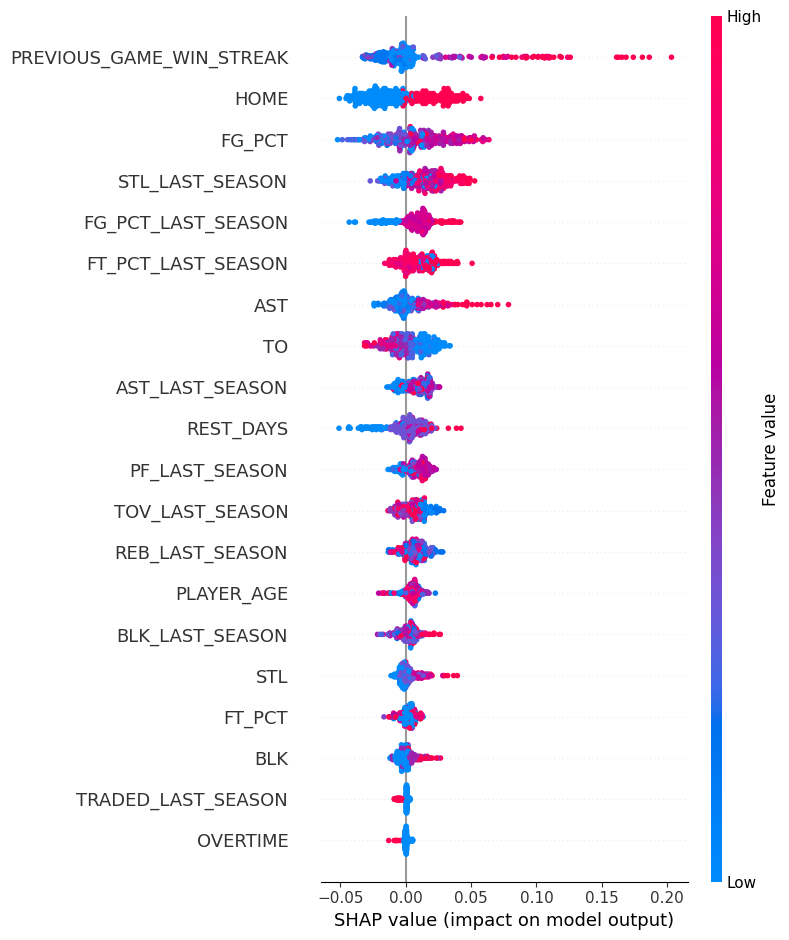

In [ ]:
shap.summary_plot(shap_values, features = X_test_selected, feature_names = X_test_selected.columns)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

seed = random_numbers[1]

def objective(trial):
    # Define the parameter search space for XGBoost
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        'scale_pos_weight': 0.7,
        'random_state': seed
    }

    # Part 1: Feature Selection with XGBoost
    selection_model = XGBClassifier(**param)
    selection_model.fit(X_train, y_train)

    selector = SelectFromModel(selection_model, prefit=True, threshold='mean', max_features = 20)
    selected_indices = selector.get_support()
    selected_features = X_train.columns[selected_indices].tolist()

    trial.set_user_attr('selected_features', selected_features)

    X_train_selected = X_train.iloc[:, selected_indices]
    X_val_selected = X_val.iloc[:, selected_indices]

    # Part 2: Train final XGBoost model on selected features
    dtrain = xgb.DMatrix(X_train_selected, label=y_train)
    dval = xgb.DMatrix(X_val_selected, label=y_val)

    xgb_params = {
        "num_parallel_tree": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "scale_pos_weight": 0.7,
        "random_state": seed
    }

    model = xgb.train(xgb_params, dtrain)
    preds = model.predict(dval)
    pred_labels = np.rint(preds)

    f1_neg = f1_score(y_val, pred_labels, pos_label = 0)

    return f1_neg


# Create study object
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed))

# Run optimization process
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Print best trial and best hyperparameters
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)
print("Best features:", study.best_trial.user_attrs['selected_features'])

[I 2025-03-02 23:19:09,184] A new study created in memory with name: no-name-8363f6ca-bd88-4f1e-91e8-a2f3d319a6a5


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-03-02 23:19:14,375] Trial 0 finished with value: 0.5616438356164384 and parameters: {'n_estimators': 61, 'max_depth': 38, 'learning_rate': 0.04123708678399252, 'subsample': 0.6915135856069714, 'colsample_bytree': 0.6204748276604233, 'min_child_weight': 8, 'gamma': 0.0015373295672806372, 'alpha': 0.00028720395590996873, 'lambda': 0.0007955466997182769}. Best is trial 0 with value: 0.5616438356164384.
[I 2025-03-02 23:19:27,996] Trial 1 finished with value: 0.4019607843137255 and parameters: {'n_estimators': 131, 'max_depth': 32, 'learning_rate': 0.019186383589751135, 'subsample': 0.9033823775767764, 'colsample_bytree': 0.6365215967350422, 'min_child_weight': 9, 'gamma': 2.025853995031934e-06, 'alpha': 0.000593526715872979, 'lambda': 0.0001516333215283554}. Best is trial 0 with value: 0.5616438356164384.
[I 2025-03-02 23:19:55,686] Trial 2 finished with value: 0.4019607843137255 and parameters: {'n_estimators': 476, 'max_depth': 87, 'learning_rate': 0.013367864145349701, 'subsamp

In [ ]:
# Store the best features and how often each feature is selected
best_features = study.best_trial.user_attrs['selected_features']
# Collect the best features
all_selected_features.append(best_features)
# Count how often each feature is selected
for feature in best_features:
    feature_selection_counts[feature] = feature_selection_counts.get(feature, 0) + 1

# Step 4: Train Final Model on Train + Validation Data with Best Features
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

X_train_val_selected = X_train_val[best_features]
X_test_selected = X_test[best_features]

dtrain_final = xgb.DMatrix(X_train_val_selected, label=y_train_val)
dtest_final = xgb.DMatrix(X_test_selected, label=y_test)

best_xgb_params = study.best_params
best_xgb_params['random_state'] = seed
best_xgb_params['num_parallel_tree'] = study.best_params['n_estimators']
del best_xgb_params['n_estimators']
best_xgb_params['scale_pos_weight'] = 0.7
final_model = xgb.train(best_xgb_params, dtrain_final)

# Step 5: Evaluate on Test Set
test_preds = final_model.predict(dtest_final)
test_pred_labels = np.rint(test_preds)

print(f"Accuracy: {accuracy_score(y_test, test_pred_labels):.3f}")
print(f"F1 Score: {f1_score(y_test, test_pred_labels):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, test_pred_labels, pos_label = 0):.3f}")
print(f"Specificity: {precision_score(y_test, test_pred_labels):.3f}")
print(f"Sensitivity: {recall_score(y_test, test_pred_labels):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, test_pred_labels):.3f}")
print(confusion_matrix(y_test, test_pred_labels))

Accuracy: 0.909
F1 Score: 0.930
F1 Score - Negative: 0.871
Specificity: 0.990
Sensitivity: 0.876
ROC AUC: 0.929
[[105   2]
 [ 29 205]]


In [ ]:
# Calculate SHAP values for the selected features
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_selected)

all_shap_values.append(shap_values)
all_feature_values.append(X_test_selected.values)

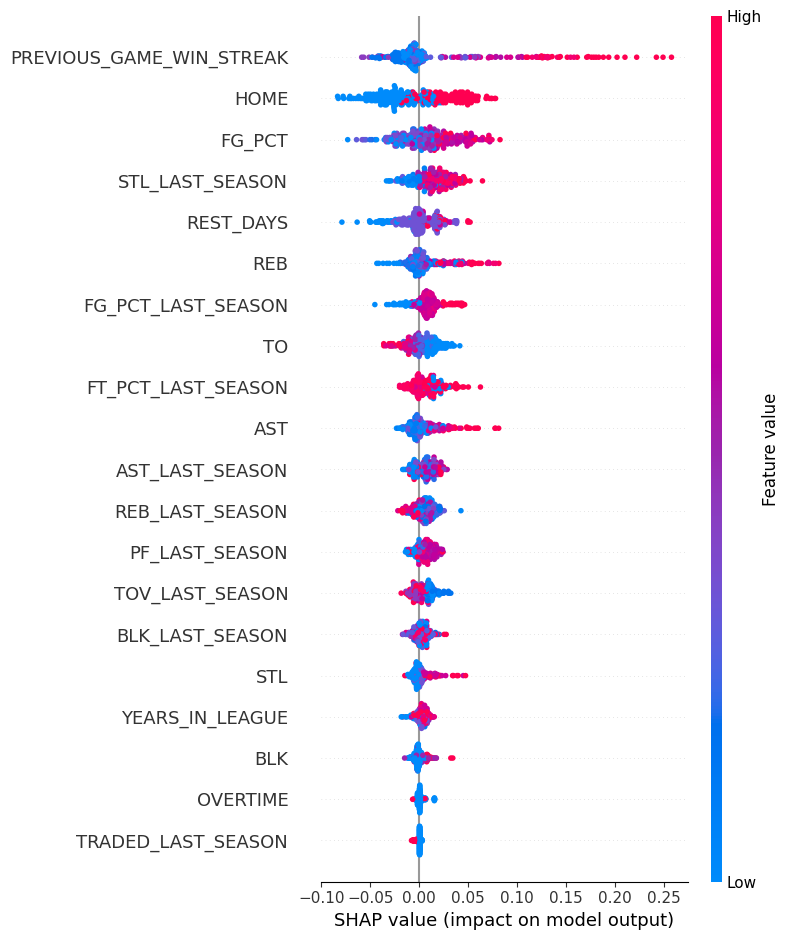

In [ ]:
shap.summary_plot(shap_values, features = X_test_selected, feature_names = X_test_selected.columns)

In [25]:
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

seed = random_numbers[2]

def objective(trial):
    # Define the parameter search space for XGBoost
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        'scale_pos_weight': 0.7,
        'random_state': seed
    }

    # Part 1: Feature Selection with XGBoost
    selection_model = XGBClassifier(**param)
    selection_model.fit(X_train, y_train)

    selector = SelectFromModel(selection_model, prefit=True, threshold='mean', max_features = 20)
    selected_indices = selector.get_support()
    selected_features = X_train.columns[selected_indices].tolist()

    trial.set_user_attr('selected_features', selected_features)

    X_train_selected = X_train.iloc[:, selected_indices]
    X_val_selected = X_val.iloc[:, selected_indices]

    # Part 2: Train final XGBoost model on selected features
    dtrain = xgb.DMatrix(X_train_selected, label=y_train)
    dval = xgb.DMatrix(X_val_selected, label=y_val)

    xgb_params = {
        "num_parallel_tree": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "scale_pos_weight": 0.7,
        "random_state": seed
    }

    model = xgb.train(xgb_params, dtrain)
    preds = model.predict(dval)
    pred_labels = np.rint(preds)

    f1_neg = f1_score(y_val, pred_labels, pos_label = 0)

    return f1_neg


# Create study object
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed))

# Run optimization process
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Print best trial and best hyperparameters
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)
print("Best features:", study.best_trial.user_attrs['selected_features'])

[I 2025-03-29 18:51:09,919] A new study created in memory with name: no-name-0637fbc3-ec09-48ce-81c8-13634c8fdd43


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-03-29 18:51:22,311] Trial 0 finished with value: 0.4019607843137255 and parameters: {'n_estimators': 300, 'max_depth': 34, 'learning_rate': 0.002183584111829915, 'subsample': 0.2090503979376493, 'colsample_bytree': 0.3103967537730456, 'min_child_weight': 7, 'gamma': 0.0874506178340428, 'alpha': 0.023028454525863044, 'lambda': 2.6602615417851744e-05}. Best is trial 0 with value: 0.4019607843137255.
[I 2025-03-29 18:51:28,460] Trial 1 finished with value: 0.4019607843137255 and parameters: {'n_estimators': 266, 'max_depth': 41, 'learning_rate': 0.005864792342527788, 'subsample': 0.876140436264444, 'colsample_bytree': 0.4145360075139576, 'min_child_weight': 3, 'gamma': 0.02242537380871492, 'alpha': 0.06412502095481536, 'lambda': 3.537526113715132e-06}. Best is trial 0 with value: 0.4019607843137255.
[I 2025-03-29 18:51:49,961] Trial 2 finished with value: 0.4019607843137255 and parameters: {'n_estimators': 246, 'max_depth': 83, 'learning_rate': 0.012136937336564176, 'subsample': 0

In [26]:
# Store the best features and how often each feature is selected
best_features = study.best_trial.user_attrs['selected_features']
# Collect the best features
all_selected_features.append(best_features)
# Count how often each feature is selected
for feature in best_features:
    feature_selection_counts[feature] = feature_selection_counts.get(feature, 0) + 1

# Step 4: Train Final Model on Train + Validation Data with Best Features
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

X_train_val_selected = X_train_val[best_features]
X_test_selected = X_test[best_features]

dtrain_final = xgb.DMatrix(X_train_val_selected, label=y_train_val)
dtest_final = xgb.DMatrix(X_test_selected, label=y_test)

best_xgb_params = study.best_params
best_xgb_params['random_state'] = seed
best_xgb_params['num_parallel_tree'] = study.best_params['n_estimators']
del best_xgb_params['n_estimators']
best_xgb_params['scale_pos_weight'] = 0.7
final_model = xgb.train(best_xgb_params, dtrain_final)

# Step 5: Evaluate on Test Set
test_preds = final_model.predict(dtest_final)
test_pred_labels = np.rint(test_preds)

print(f"Accuracy: {accuracy_score(y_test, test_pred_labels):.3f}")
print(f"F1 Score: {f1_score(y_test, test_pred_labels):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, test_pred_labels, pos_label = 0):.3f}")
print(f"Specificity: {precision_score(y_test, test_pred_labels):.3f}")
print(f"Sensitivity: {recall_score(y_test, test_pred_labels):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, test_pred_labels):.3f}")
print(confusion_matrix(y_test, test_pred_labels))

Accuracy: 0.871
F1 Score: 0.898
F1 Score - Negative: 0.825
Specificity: 0.985
Sensitivity: 0.825
ROC AUC: 0.898
[[104   3]
 [ 41 193]]


In [53]:
test_preds

array([0.38283715, 0.3902143 , 0.425844  , 0.3788775 , 0.44730508,
       0.3856787 , 0.31200978, 0.38638043, 0.43155426, 0.38125768,
       0.39320406, 0.43608466, 0.45123082, 0.48886502, 0.43340182,
       0.46252993, 0.4905772 , 0.4375904 , 0.5123123 , 0.68500143,
       0.6765742 , 0.6881195 , 0.68668205, 0.65098095, 0.66711944,
       0.6588844 , 0.6355034 , 0.6299112 , 0.5860222 , 0.6116469 ,
       0.62574494, 0.59941614, 0.6371205 , 0.56116545, 0.61671513,
       0.48168814, 0.52670604, 0.5701761 , 0.4747675 , 0.54520327,
       0.54697746, 0.55744976, 0.58089644, 0.5842391 , 0.5266277 ,
       0.563747  , 0.46784893, 0.5564719 , 0.5429075 , 0.57649684,
       0.53555125, 0.56811345, 0.5303676 , 0.52292657, 0.51053643,
       0.5179841 , 0.50776   , 0.49391004, 0.59047675, 0.59931177,
       0.6131141 , 0.6787014 , 0.602627  , 0.61155224, 0.6041968 ,
       0.58977914, 0.5750901 , 0.5197912 , 0.60939753, 0.55162203,
       0.49908796, 0.50684893, 0.5515073 , 0.51803607, 0.46021

In [27]:
# Calculate SHAP values for the selected features
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_selected)

all_shap_values.append(shap_values)
all_feature_values.append(X_test_selected.values)

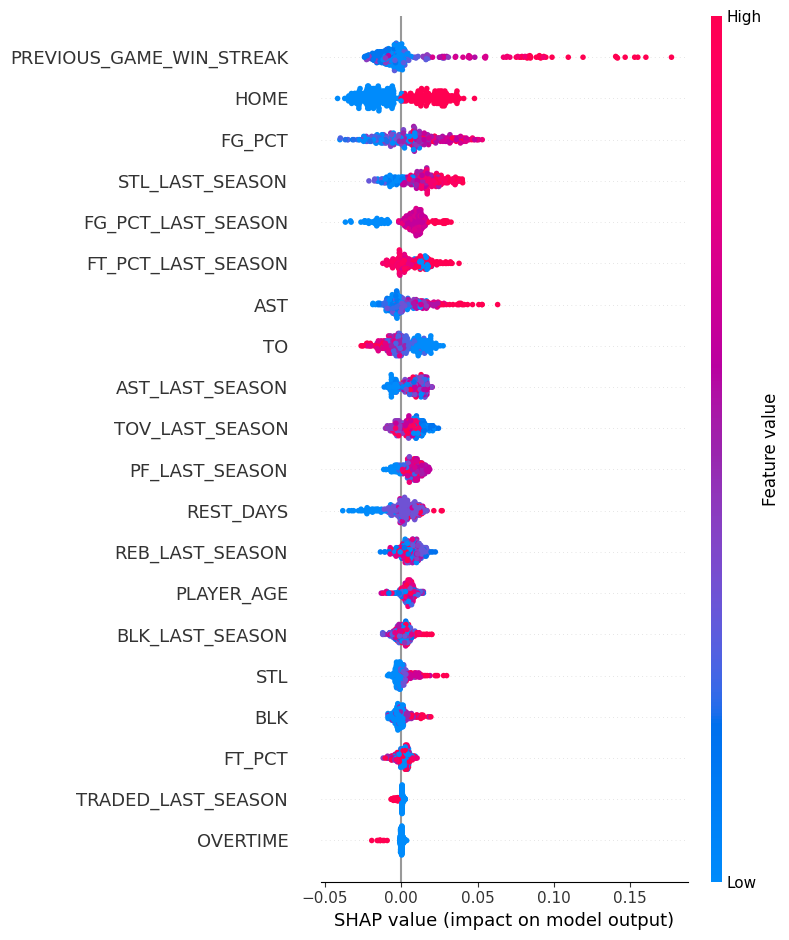

In [28]:
shap.summary_plot(shap_values, features = X_test_selected, feature_names = X_test_selected.columns)

In [29]:
shap_values[1, :]

array([-0.01463101, -0.00084973, -0.02240875, -0.007169  , -0.00609575,
        0.00193019, -0.00863652, -0.00069403, -0.00529568, -0.00794177,
        0.00756986, -0.00625644,  0.01056343,  0.00815344,  0.01315913,
        0.00491678, -0.00650869,  0.00894079, -0.00312125,  0.00328414],
      dtype=float32)

In [30]:
X_test.iloc[1, :]

HOME                       0.000
OVERTIME                   0.000
REST_DAYS                  1.000
PREVIOUS_GAME_WIN_STREAK   0.000
FG_PCT                     0.417
                            ... 
PLAYER_ID_1642439          0.000
PLAYER_ID_1642450          0.000
PLAYER_ID_1642461          0.000
PLAYER_ID_1642505          0.000
PLAYER_ID_1642530          0.000
Name: 35, Length: 985, dtype: float64

In [100]:
shap.initjs()

In [74]:
teams_gamelog_df[((teams_gamelog_df['MATCHUP'] == 		'NYK @ ORL')| (teams_gamelog_df['MATCHUP'] == 		'NYK vs. ORL'))	& (teams_gamelog_df['TEAM_NAME'] == 		'New York Knicks')]

Team_ID   Game_ID     GAME_DATE      MATCHUP WL      W      L  W_PCT  \
524  1610612752  22400419  DEC 27, 2024    NYK @ ORL  W 21.000 10.000  0.677   
529  1610612752  22401227  DEC 15, 2024    NYK @ ORL  W 16.000 10.000  0.615   
534  1610612752  22400053  DEC 03, 2024  NYK vs. ORL  W 13.000  8.000  0.619   

     MIN  FGM  FGA  FG_PCT  FG3M  FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  \
524  240   40   75   0.533     4    15    0.267   24   34   0.706    12    32   
529  240   33   71   0.465    10    24    0.417   24   30   0.800     7    38   
534  240   43   85   0.506    15    35    0.429   20   20   1.000     5    34   

     REB  AST  STL  BLK  TOV  PF  PTS        TEAM_NAME  
524   44   18   10    3   18  20  108  New York Knicks  
529   45   20    8    3   17  16  100  New York Knicks  
534   39   30    6    4   17  25  121  New York Knicks

In [75]:
teams_gamelog_df[ teams_gamelog_df['TEAM_NAME'] == 		'New York Knicks']

Team_ID   Game_ID     GAME_DATE      MATCHUP WL      W      L  W_PCT  \
519  1610612752  22400482  JAN 04, 2025    NYK @ CHI  L 24.000 12.000  0.667   
520  1610612752  22400473  JAN 03, 2025    NYK @ OKC  L 24.000 11.000  0.686   
521  1610612752  22400458  JAN 01, 2025  NYK vs. UTA  W 24.000 10.000  0.706   
522  1610612752  22400443  DEC 30, 2024    NYK @ WAS  W 23.000 10.000  0.697   
523  1610612752  22400429  DEC 28, 2024    NYK @ WAS  W 22.000 10.000  0.688   
524  1610612752  22400419  DEC 27, 2024    NYK @ ORL  W 21.000 10.000  0.677   
525  1610612752  22400405  DEC 25, 2024  NYK vs. SAS  W 20.000 10.000  0.667   
526  1610612752  22400397  DEC 23, 2024  NYK vs. TOR  W 19.000 10.000  0.655   
527  1610612752  22400384  DEC 21, 2024    NYK @ NOP  W 18.000 10.000  0.643   
528  1610612752  22400367  DEC 19, 2024    NYK @ MIN  W 17.000 10.000  0.630   
529  1610612752  22401227  DEC 15, 2024    NYK @ ORL  W 16.000 10.000  0.615   
530  1610612752  22401202  DEC 11, 2024  NYK vs. ATL  L 15.000 10.000  0.600   
531  1610612752  22400359  DEC 09, 2024    NYK @ TOR  W 15.000  9.000  0.625   
532  1610612752  22400343  DEC 07, 2024  NYK vs. DET  L 14.000  9.000  0.609   
533  1610612752  22400327  DEC 05, 2024  NYK vs. CHA  W 14.000  8.000  0.636   
534  1610612752  22400053  DEC 03, 2024  NYK vs. ORL  W 13.000  8.000  0.619   
535  1610612752  22400308  DEC 01, 2024  NYK vs. NOP  W 12.000  8.000  0.600   
536  1610612752  22400040  NOV 29, 2024    NYK @ CHA  W 11.000  8.000  0.579   
537  1610612752  22400292  NOV 27, 2024    NYK @ DAL  L 10.000  8.000  0.556   
538  1610612752  22400283  NOV 25, 2024    NYK @ DEN  W 10.000  7.000  0.588   
539  1610612752  22400264  NOV 23, 2024    NYK @ UTA  L  9.000  7.000  0.563   
540  1610612752  22400257  NOV 20, 2024    NYK @ PHX  W  9.000  6.000  0.600   
541  1610612752  22400246  NOV 18, 2024  NYK vs. WAS  W  8.000  6.000  0.571   
542  1610612752  22400240  NOV 17, 2024  NYK vs. BKN  W  7.000  6.000  0.538   
543  1610612752  22400014  NOV 15, 2024  NYK vs. BKN  W  6.000  6.000  0.500   
544  1610612752  22400219  NOV 13, 2024  NYK vs. CHI  L  5.000  6.000  0.455   
545  1610612752  22400004  NOV 12, 2024    NYK @ PHI  W  5.000  5.000  0.500   
546  1610612752  22400203  NOV 10, 2024    NYK @ IND  L  4.000  5.000  0.444   
547  1610612752  22400189  NOV 08, 2024  NYK vs. MIL  W  4.000  4.000  0.500   
548  1610612752  22400171  NOV 06, 2024    NYK @ ATL  L  3.000  4.000  0.429   
549  1610612752  22400161  NOV 04, 2024    NYK @ HOU  L  3.000  3.000  0.500   
550  1610612752  22400134  NOV 01, 2024    NYK @ DET  W  3.000  2.000  0.600   
551  1610612752  22400122  OCT 30, 2024    NYK @ MIA  W  2.000  2.000  0.500   
552  1610612752  22400106  OCT 28, 2024  NYK vs. CLE  L  1.000  2.000  0.333   
553  1610612752  22400081  OCT 25, 2024  NYK vs. IND  W  1.000  1.000  0.500   
554  1610612752  22400061  OCT 22, 2024    NYK @ BOS  L  0.000  1.000  0.000   

     MIN  FGM  FGA  FG_PCT  FG3M  FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  \
519  240   48   97   0.495     8    30    0.267   22   28   0.786    18    31   
520  240   43   90   0.478     9    32    0.281   12   17   0.706    11    31   
521  240   47   85   0.553     9    23    0.391   16   23   0.696     6    41   
522  240   45   98   0.459    15    44    0.341   21   25   0.840    15    39   
523  265   51   97   0.526    10    40    0.250   24   26   0.923    10    33   
524  240   40   75   0.533     4    15    0.267   24   34   0.706    12    32   
525  240   45  100   0.450    13    39    0.333   14   16   0.875    17    30   
526  240   51   86   0.593    17    37    0.459   20   29   0.690     8    27   
527  240   38   87   0.437    15    37    0.405   13   15   0.867    15    27   
528  240   50   97   0.515    20    45    0.444   13   16   0.813    16    41   
529  240   33   71   0.465    10    24    0.417   24   30   0.800     7    38   
530  240   40   93   0.430    11    42    0.262    9   15   0.600    12    

In [76]:
teams_gamelog_df[teams_gamelog_df['Game_ID'] == 		22400081	]

Team_ID   Game_ID     GAME_DATE      MATCHUP WL     W     L  W_PCT  \
553  1610612752  22400081  OCT 25, 2024  NYK vs. IND  W 1.000 1.000  0.500   
625  1610612754  22400081  OCT 25, 2024    IND @ NYK  L 1.000 1.000  0.500   

     MIN  FGM  FGA  FG_PCT  FG3M  FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  \
553  240   44   84   0.524    12    27    0.444   23   29   0.793    11    32   
625  240   41   83   0.494     3    30    0.100   13   20   0.650     9    24   

     REB  AST  STL  BLK  TOV  PF  PTS        TEAM_NAME  
553   43   19    5    4   11  18  123  New York Knicks  
625   33   28    8    6   15  24   98   Indiana Pacers

In [78]:
teams_gamelog_df[teams_gamelog_df['Game_ID'] == 22400203]

Team_ID   Game_ID     GAME_DATE      MATCHUP WL     W     L  W_PCT  \
546  1610612752  22400203  NOV 10, 2024    NYK @ IND  L 4.000 5.000  0.444   
617  1610612754  22400203  NOV 10, 2024  IND vs. NYK  W 5.000 5.000  0.500   

     MIN  FGM  FGA  FG_PCT  FG3M  FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  \
546  240   46   83   0.554     7    25    0.280   22   27   0.815     8    31   
617  240   45   88   0.511    21    46    0.457   21   25   0.840     5    27   

     REB  AST  STL  BLK  TOV  PF  PTS        TEAM_NAME  
546   39   23    5    3   13  20  121  New York Knicks  
617   32   27    6    4    6  22  132   Indiana Pacers

In [46]:
pd.set_option('display.max_rows', None)

In [79]:
X_test_chk  = final_df[final_df['TEAM_NYK'] == 1].reset_index()

In [83]:
X_test_chk[( X_test_chk['PLAYER_NAME'] == 'OG Anunoby') & ((X_test_chk['GAME_ID'] == 22400081) |  (X_test_chk['GAME_ID'] == 22400203))]

index   GAME_ID     TEAM_ID TEAM_ABBREVIATION TEAM_CITY  PLAYER_ID  \
255   6693  22400203  1610612752               NYK  New York    1628384   
317   9056  22400081  1610612752               NYK  New York    1628384   

    PLAYER_NAME NICKNAME START_POSITION  COMMENT           MIN   FGM    FGA  \
255  OG Anunoby       OG              F      NaN  36.000000:06 9.000 14.000   
317  OG Anunoby       OG              F      NaN  34.000000:01 6.000 12.000   

     FG_PCT  FG3M  FG3A  FG3_PCT   FTM   FTA  FT_PCT  OREB  DREB   REB   AST  \
255   0.643 3.000 4.000    0.750 4.000 4.000   1.000 2.000 2.000 4.000 2.000   
317   0.500 1.000 4.000    0.250 1.000 2.000   0.500 0.000 4.000 4.000 1.000   

      STL   BLK    TO    PF    PTS  PLUS_MINUS       POSITION HEIGHT  WEIGHT  \
255 2.000 0.000 3.000 3.000 25.000      -2.000  Forward-Guard    6-7 240.000   
317 1.000 0.000 1.000 3.000 14.000      18.000  Forward-Guard    6-7 240.000   

     YEARS_IN_LEAGUE   GAME_DATE  GAME_MIN     W  HOME  OVERTIME  REST_DAYS  \
255            8.000  2024-11-10   240.000 0.000 0.000     0.000      2.000   
317            8.000  2024-10-25   240.000 1.000 1.000     0.000      3.000   

     MIN_LAST_SEASON  FGM_LAST_SEASON  FGA_LAST_SEASON  FG_PCT_LAST_SEASON  \
255         1702.000          282.000          577.000               0.489   
317         1702.000          282.000          577.000               0.489   

     FG3M_LAST_SEASON  FG3A_LAST_SEASON  FG3_PCT_LAST_SEASON  FTM_LAST_SEASON  \
255           102.000           267.000                0.382           67.000   
317           102.000           267.000                0.382           67.000   

     FTA_LAST_SEASON  FT_PCT_LAST_SEASON  OREB_LAST_SEASON  DREB_LAST_SEASON  \
255           89.000               0.753            47.000           161.000   
317           89.000               0.753            47.000           161.000   

     REB_LAST_SEASON  AST_LAST_SEASON  STL_LAST_SEASON  BLK_LAST_SEASON  \
255          208.000          107.000           68.000           36.000   
317          208.000          107.000           68.000           36.000   

     TOV_LAST_SEASON  PF_LAST_SEASON  PTS_LAST_SEASON  TRADED_LAST_SEASON  \
255           81.000         119.000          733.000               1.000   
317           81.000         119.000          733.000               1.000   

     PLAYER_AGE  TRADED_THIS_SEASON  Height_in_Inches  POS_G  POS_F  POS_C  \
255      27.000                   0                79      0      0      0   
317      27.000                   0                79      0      0      0   

     POS_FC  POS_GF  POS_CF  POS_FG  START_POS_F  START_POS_G  START_POS_C  \
255       0       0       0       1            1            0            0   
317       0       0       0       1            1            0            0   

     TEAM_GSW  TEAM_OKC  TEAM_CHI  TEAM_MEM  TEAM_ORL  TEAM_SAS  TEAM_DAL  \
255         0         0         0         0         0         0         0   
317         0         0         0         0         0         0         0   

     TEAM_TOR  TEAM_LAC  TEAM_PHI  TEAM_SAC  TEAM_BOS  TEAM_IND  TEAM_DET  \
255         0         0         0         0         0         0         0   
317         0         0         0         0         0         0         0   

     TEAM_MIL  TEAM_CLE  TEAM_WAS  TEAM_CHA  TEAM_HOU  TEAM_DEN  TEAM_PHX  \
255         0         0         0         0         0         0         0   
317         0         0         0         0         0         0         0   

     TEAM_MIA  TEAM_UTA  TEAM_LAL  TEAM_POR  TEAM_MIN  TEAM_NYK  TEAM_BKN  \
255         0         0         0         0         0         1         0   
317         0         0         0         0         0         1         0   

     TEAM_ATL  TEAM_NOP  TOTAL_MIN  PREVIOUS_GAME_WIN_STREAK  
255         0         0     36.100                     1.000  
317         0         0     34.017                     0.000

In [88]:
X_test_selected.iloc[317,:]

HOME                         1.000
OVERTIME                     0.000
REST_DAYS                    3.000
PREVIOUS_GAME_WIN_STREAK     0.000
FG_PCT                       0.500
FT_PCT                       0.500
AST                          1.000
STL                          1.000
BLK                          0.000
TO                           1.000
FG_PCT_LAST_SEASON           0.489
FT_PCT_LAST_SEASON           0.753
REB_LAST_SEASON            208.000
AST_LAST_SEASON            107.000
STL_LAST_SEASON             68.000
BLK_LAST_SEASON             36.000
TOV_LAST_SEASON             81.000
PF_LAST_SEASON             119.000
TRADED_LAST_SEASON           1.000
PLAYER_AGE                  27.000
Name: 9056, dtype: float64

In [52]:
y_pred

array([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,

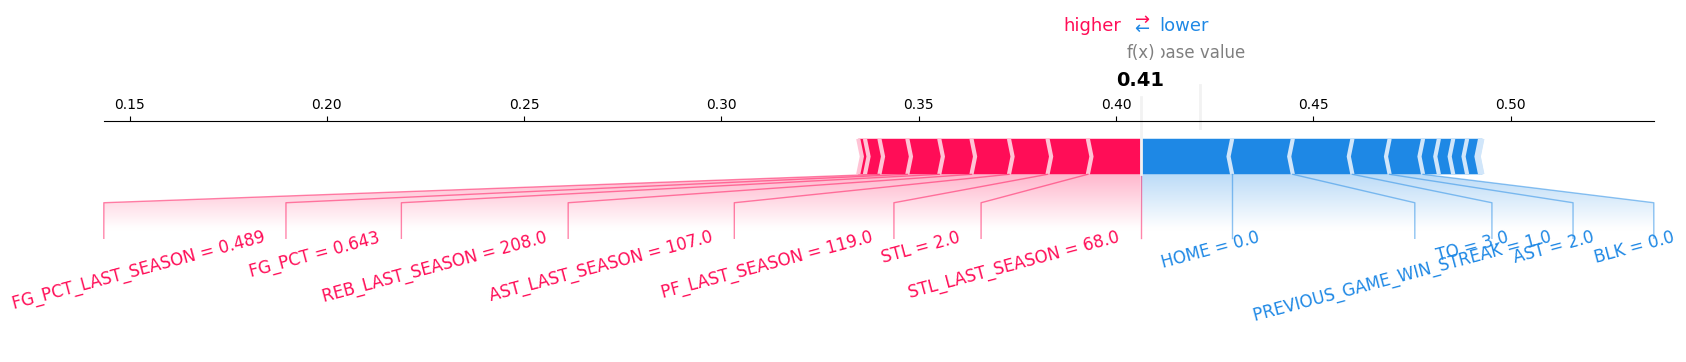

In [86]:
shap.initjs()
shap.plots.force(explainer.expected_value, shap_values[255, :], X_test_selected.iloc[255, :], matplotlib=True, text_rotation=15)

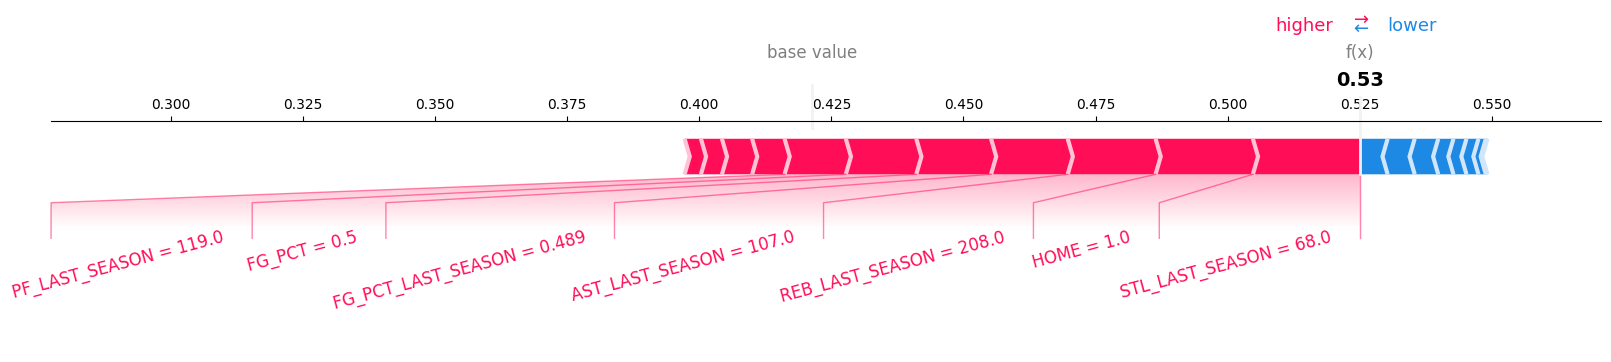

In [87]:
shap.initjs()
shap.plots.force(explainer.expected_value, shap_values[317, :], X_test_selected.iloc[317, :], matplotlib=True, text_rotation=15)

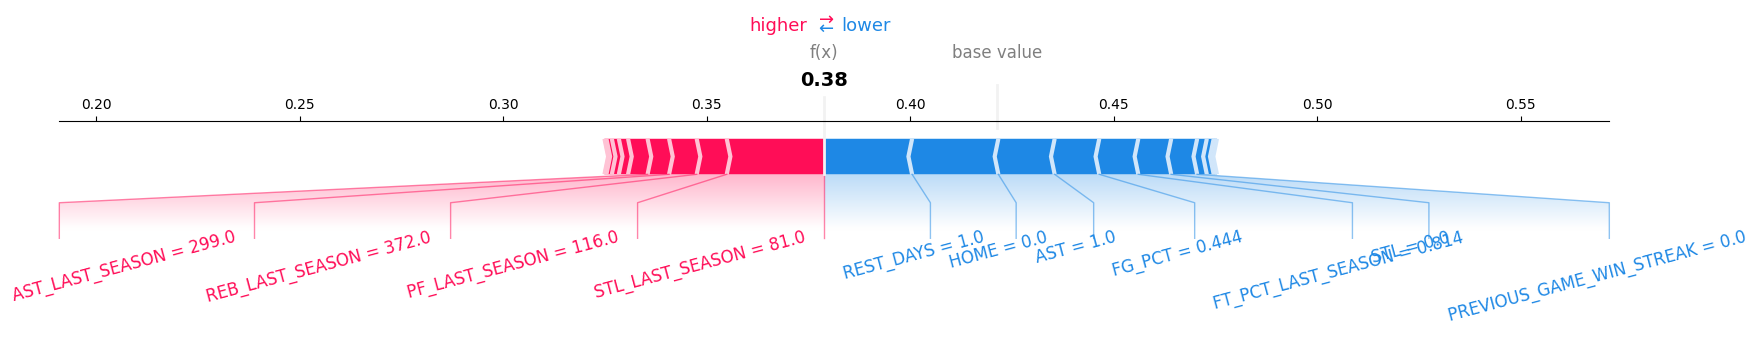

In [39]:
shap.initjs()
shap.plots.force(explainer.expected_value, shap_values[3, :], X_test_selected.iloc[3, :], matplotlib=True, text_rotation=15)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values.values[3, :], X_test.iloc[3, :])

In [ ]:
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

seed = random_numbers[3]

def objective(trial):
    # Define the parameter search space for XGBoost
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        'scale_pos_weight': 0.7,
        'random_state': seed
    }

    # Part 1: Feature Selection with XGBoost
    selection_model = XGBClassifier(**param)
    selection_model.fit(X_train, y_train)

    selector = SelectFromModel(selection_model, prefit=True, threshold='mean', max_features = 20)
    selected_indices = selector.get_support()
    selected_features = X_train.columns[selected_indices].tolist()

    trial.set_user_attr('selected_features', selected_features)

    X_train_selected = X_train[selected_features]
    X_val_selected = X_val[selected_features]

    # Part 2: Train final XGBoost model on selected features
    dtrain = xgb.DMatrix(X_train_selected, label=y_train)
    dval = xgb.DMatrix(X_val_selected, label=y_val)

    xgb_params = {
        "num_parallel_tree": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "scale_pos_weight": 0.7,
        "random_state": seed
    }

    model = xgb.train(xgb_params, dtrain)
    preds = model.predict(dval)
    pred_labels = np.rint(preds)

    f1_neg = f1_score(y_val, pred_labels, pos_label = 0)

    return f1_neg


# Create study object
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed))

# Run optimization process
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Print best trial and best hyperparameters
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)
print("Best features:", study.best_trial.user_attrs['selected_features'])

[I 2025-03-02 23:41:20,363] A new study created in memory with name: no-name-6dada4f7-85fd-41e3-b730-76894c3c0f03


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-03-02 23:41:27,659] Trial 0 finished with value: 0.4019607843137255 and parameters: {'n_estimators': 337, 'max_depth': 100, 'learning_rate': 0.023627827609453624, 'subsample': 0.6111938796197133, 'colsample_bytree': 0.20774194781646466, 'min_child_weight': 2, 'gamma': 0.0017510634751710323, 'alpha': 4.075710153720226e-06, 'lambda': 2.5856616761906693e-08}. Best is trial 0 with value: 0.4019607843137255.
[I 2025-03-02 23:41:36,102] Trial 1 finished with value: 0.4019607843137255 and parameters: {'n_estimators': 151, 'max_depth': 76, 'learning_rate': 0.0010201913272454457, 'subsample': 0.239261865893958, 'colsample_bytree': 0.7387292565055985, 'min_child_weight': 8, 'gamma': 0.005507219423705535, 'alpha': 1.137698993208835e-06, 'lambda': 0.26482912049627877}. Best is trial 0 with value: 0.4019607843137255.
[I 2025-03-02 23:41:53,087] Trial 2 finished with value: 0.4019607843137255 and parameters: {'n_estimators': 219, 'max_depth': 27, 'learning_rate': 0.0035887301906811233, 'subs

In [ ]:
# Store the best features and how often each feature is selected
best_features = study.best_trial.user_attrs['selected_features']
# Collect the best features
all_selected_features.append(best_features)
# Count how often each feature is selected
for feature in best_features:
    feature_selection_counts[feature] = feature_selection_counts.get(feature, 0) + 1

# Step 4: Train Final Model on Train + Validation Data with Best Features
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

X_train_val_selected = X_train_val[best_features]
X_test_selected = X_test[best_features]

dtrain_final = xgb.DMatrix(X_train_val_selected, label=y_train_val)
dtest_final = xgb.DMatrix(X_test_selected, label=y_test)

best_xgb_params = study.best_params
best_xgb_params['random_state'] = seed
best_xgb_params['num_parallel_tree'] = study.best_params['n_estimators']
del best_xgb_params['n_estimators']
best_xgb_params['scale_pos_weight'] =0.7
final_model = xgb.train(best_xgb_params, dtrain_final)

# Step 5: Evaluate on Test Set
test_preds = final_model.predict(dtest_final)
test_pred_labels = np.rint(test_preds)

print(f"Accuracy: {accuracy_score(y_test, test_pred_labels):.3f}")
print(f"F1 Score: {f1_score(y_test, test_pred_labels):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, test_pred_labels, pos_label = 0):.3f}")
print(f"Specificity: {precision_score(y_test, test_pred_labels):.3f}")
print(f"Sensitivity: {recall_score(y_test, test_pred_labels):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, test_pred_labels):.3f}")
print(confusion_matrix(y_test, test_pred_labels))

Accuracy: 0.880
F1 Score: 0.905
F1 Score - Negative: 0.837
Specificity: 0.990
Sensitivity: 0.833
ROC AUC: 0.907
[[105   2]
 [ 39 195]]


In [ ]:
# Calculate SHAP values for the selected features
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_selected)

all_shap_values.append(shap_values)
all_feature_values.append(X_test_selected.values)

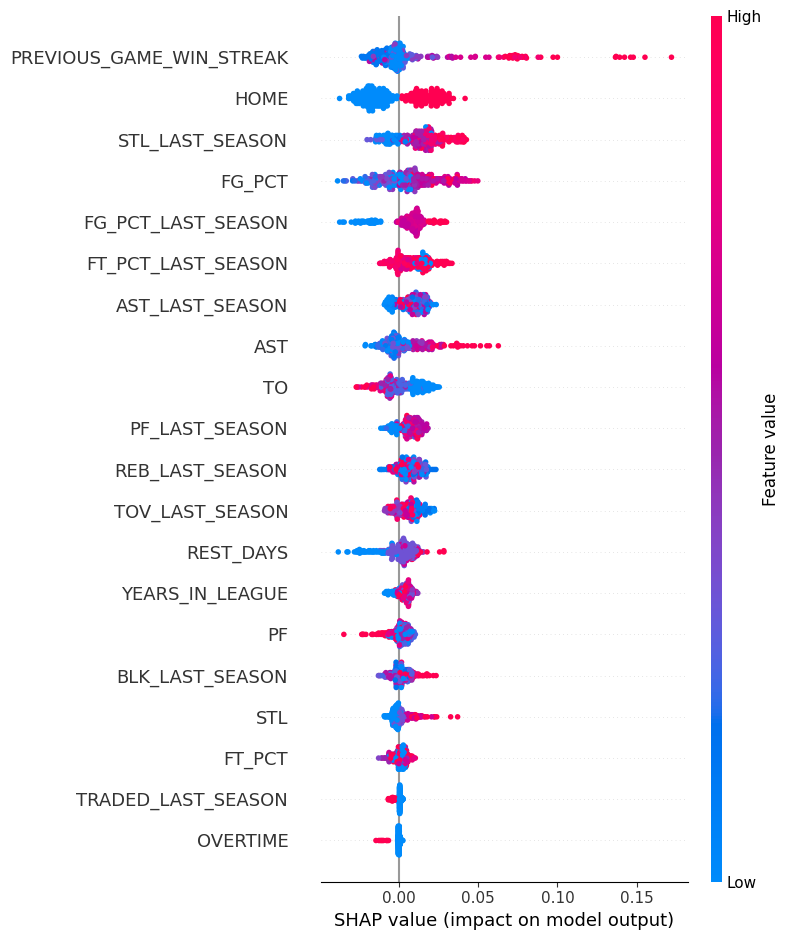

In [ ]:
shap.summary_plot(shap_values, features = X_test_selected, feature_names = X_test_selected.columns)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

seed = random_numbers[4]

def objective(trial):
    # Define the parameter search space for XGBoost
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        'scale_pos_weight': 0.7,
        'random_state': seed
    }

    # Part 1: Feature Selection with XGBoost
    selection_model = XGBClassifier(**param)
    selection_model.fit(X_train, y_train)

    selector = SelectFromModel(selection_model, prefit=True, threshold='mean', max_features = 20)
    selected_indices = selector.get_support()
    selected_features = X_train.columns[selected_indices].tolist()

    trial.set_user_attr('selected_features', selected_features)

    X_train_selected = X_train.iloc[:, selected_indices]
    X_val_selected = X_val.iloc[:, selected_indices]

    # Part 2: Train final XGBoost model on selected features
    dtrain = xgb.DMatrix(X_train_selected, label=y_train)
    dval = xgb.DMatrix(X_val_selected, label=y_val)

    xgb_params = {
        "num_parallel_tree": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "scale_pos_weight": 0.7,
        "random_state": seed
    }

    model = xgb.train(xgb_params, dtrain)
    preds = model.predict(dval)
    pred_labels = np.rint(preds)

    f1_neg = f1_score(y_val, pred_labels, pos_label = 0)


    return f1_neg

# Create study object
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed))

# Run optimization process
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Print best trial and best hyperparameters
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)
print("Best features:", study.best_trial.user_attrs['selected_features'])

[I 2025-03-02 23:52:10,051] A new study created in memory with name: no-name-21b997bf-90ad-4d4f-b1cc-f12752ebfa0f


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-03-02 23:52:11,277] Trial 0 finished with value: 0.4019607843137255 and parameters: {'n_estimators': 62, 'max_depth': 5, 'learning_rate': 0.01863436493335777, 'subsample': 0.9377672388340839, 'colsample_bytree': 0.9294474904442089, 'min_child_weight': 3, 'gamma': 7.1663750500432e-08, 'alpha': 0.799918064459378, 'lambda': 2.1997416789608766e-05}. Best is trial 0 with value: 0.4019607843137255.
[I 2025-03-02 23:52:23,303] Trial 1 finished with value: 0.4019607843137255 and parameters: {'n_estimators': 228, 'max_depth': 22, 'learning_rate': 0.0030229169776697508, 'subsample': 0.21638524365504336, 'colsample_bytree': 0.5077736877304002, 'min_child_weight': 7, 'gamma': 0.01976321898608418, 'alpha': 7.394815747326287e-05, 'lambda': 4.9852080337488745e-08}. Best is trial 0 with value: 0.4019607843137255.
[I 2025-03-02 23:52:33,533] Trial 2 finished with value: 0.4019607843137255 and parameters: {'n_estimators': 270, 'max_depth': 21, 'learning_rate': 0.003352094198862877, 'subsample': 

In [ ]:
# Store the best features and how often each feature is selected
best_features = study.best_trial.user_attrs['selected_features']
# Collect the best features
all_selected_features.append(best_features)
# Count how often each feature is selected
for feature in best_features:
    feature_selection_counts[feature] = feature_selection_counts.get(feature, 0) + 1

# Step 4: Train Final Model on Train + Validation Data with Best Features
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

X_train_val_selected = X_train_val[best_features]
X_test_selected = X_test[best_features]

dtrain_final = xgb.DMatrix(X_train_val_selected, label=y_train_val)
dtest_final = xgb.DMatrix(X_test_selected, label=y_test)

best_xgb_params = study.best_params
best_xgb_params['random_state'] = seed
best_xgb_params['num_parallel_tree'] = study.best_params['n_estimators']
del best_xgb_params['n_estimators']
best_xgb_params['scale_pos_weight'] = 0.7
final_model = xgb.train(best_xgb_params, dtrain_final)

# Step 5: Evaluate on Test Set
test_preds = final_model.predict(dtest_final)
test_pred_labels = np.rint(test_preds)

print(f"Accuracy: {accuracy_score(y_test, test_pred_labels):.3f}")
print(f"F1 Score: {f1_score(y_test, test_pred_labels):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, test_pred_labels, pos_label = 0):.3f}")
print(f"Specificity: {precision_score(y_test, test_pred_labels):.3f}")
print(f"Sensitivity: {recall_score(y_test, test_pred_labels):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, test_pred_labels):.3f}")
print(confusion_matrix(y_test, test_pred_labels))

Accuracy: 0.757
F1 Score: 0.793
F1 Score - Negative: 0.705
Specificity: 0.952
Sensitivity: 0.679
ROC AUC: 0.802
[[ 99   8]
 [ 75 159]]


In [ ]:
# Calculate SHAP values for the selected features
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_selected)

all_shap_values.append(shap_values)
all_feature_values.append(X_test_selected.values)

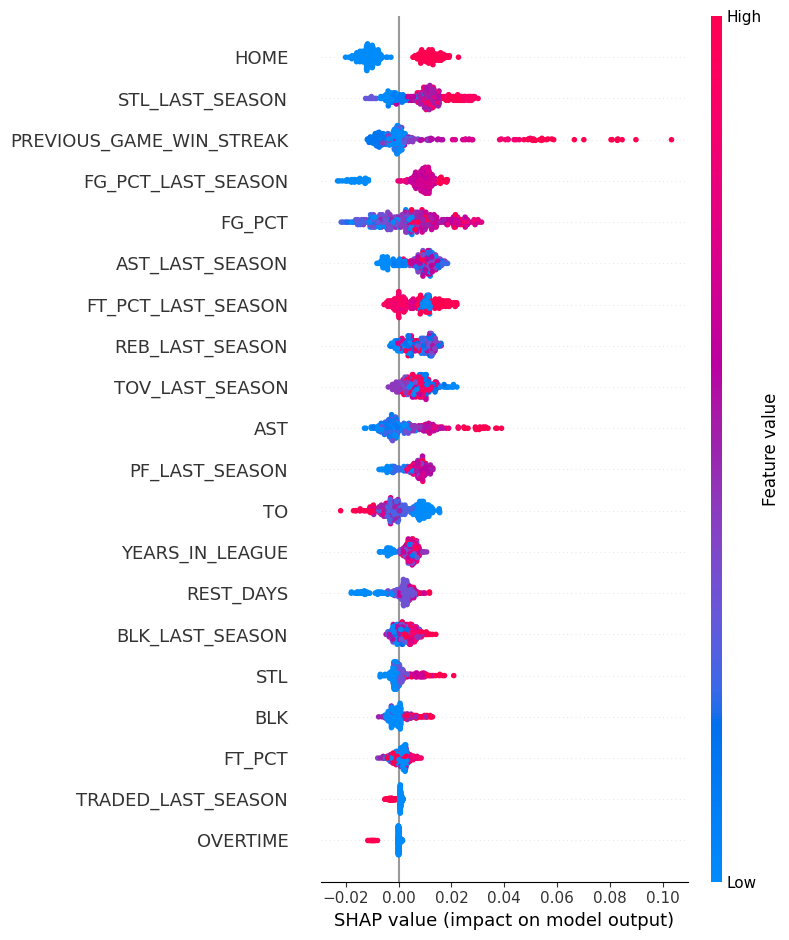

In [ ]:
shap.summary_plot(shap_values, features = X_test_selected, feature_names = X_test_selected.columns)

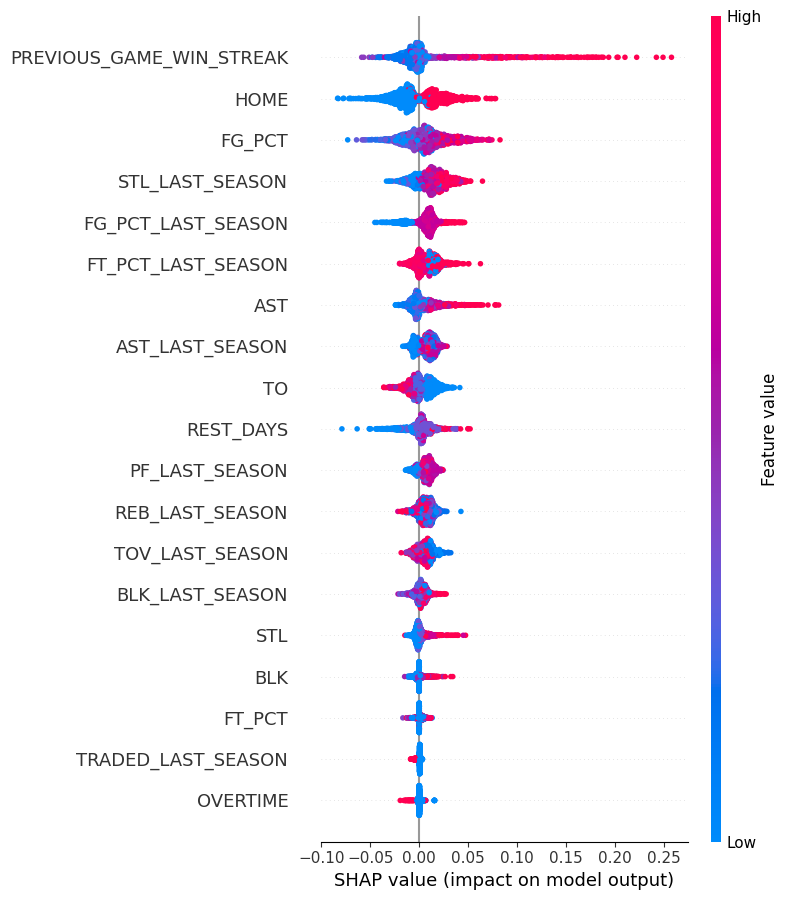

In [ ]:
# 4) Lower the threshold to 3 (any feature selected >=3 times is "consistent")
min_selection_threshold = 4 # if the feature appeared at least 4 seed, then display
consistent_features = [
    feature for feature, count in feature_selection_counts.items()
    if count >= min_selection_threshold
]

# 5) Combine seed-specific SHAP and feature data for these consistent features
shap_dfs = []
feature_dfs = []
for shap_val, feat_val, sel_feats in zip(all_shap_values, all_feature_values, all_selected_features):
    # Build DataFrames for this seed's SHAP and feature data
    df_shap = pd.DataFrame(shap_val, columns=sel_feats)
    df_feat = pd.DataFrame(feat_val, columns=sel_feats)

    # Reindex to include all consistent features (fill missing columns with 0)
    df_shap = df_shap.reindex(columns=consistent_features, fill_value=0)
    df_feat = df_feat.reindex(columns=consistent_features, fill_value=0)

    shap_dfs.append(df_shap)
    feature_dfs.append(df_feat)

# Concatenate data from all seeds along the rows
combined_shap = pd.concat(shap_dfs, axis=0)
combined_features = pd.concat(feature_dfs, axis=0)

# 6) Visualize SHAP summary plot with all consistent features
shap.summary_plot(
    combined_shap.values,
    combined_features,
    plot_type="dot",
    max_display=len(consistent_features)
)


In [ ]:
combined_features

HOME  OVERTIME  REST_DAYS  PREVIOUS_GAME_WIN_STREAK  FG_PCT  FT_PCT  \
0   0.000     0.000      1.000                     0.000   0.000   1.000   
1   0.000     0.000      1.000                     0.000   0.417   0.000   
2   0.000     0.000      1.000                     0.000   0.586   0.700   
3   0.000     0.000      1.000                     0.000   0.444   0.667   
4   0.000     0.000      1.000                     0.000   0.550   0.909   
..    ...       ...        ...                       ...     ...     ...   
336 0.000     0.000      0.000                     1.000   0.500   0.000   
337 0.000     0.000      0.000                     1.000   0.333   0.000   
338 0.000     0.000      0.000                     1.000   0.000   0.000   
339 0.000     0.000      0.000                     1.000   0.500   0.000   
340 0.000     0.000      0.000                     1.000   0.000   0.000   

       AST   STL   BLK    TO  FG_PCT_LAST_SEASON  FT_PCT_LAST_SEASON  \
0   10.000 1.000 0.000 2.000               0.434               0.791   
1    0.000 1.000 0.000 3.000               0.489               0.753   
2    5.000 1.000 0.000 3.000               0.504               0.873   
3    1.000 0.000 1.000 1.000               0.436               0.814   
4    8.000 2.000 0.000 1.000               0.479               0.847   
..     ...   ...   ...   ...                 ...                 ...   
336  4.000 1.000 0.000 1.000               0.432               0.866   
337  0.000 0.000 0.000 0.000               0.000               0.000   
338  0.000 0.000 1.000 0.000               0.000               0.000   
339  0.000 0.000 0.000 2.000               0.000               0.000   
340  0.000 0.000 0.000 0.000               0.556               1.000   

     REB_LAST_SEASON  AST_LAST_SEASON  STL_LAST_SEASON  BLK_LAST_SEASON  \
0            675.000          331.000           75.000           23.000   
1            208.000          107.000           68.000           36.000   
2            515.000          189.000           43.000           41.000   
3            372.000          299.000           81.000           30.000   
4            278.000          519.000           70.000           13.000   
..               ...              ...              ...              ...   
336          117.000          205.000           42.000           11.000   
337            0.000            0.000            0.000            0.000   
338            0.000            0.000            0.000            0.000   
339            0.000            0.000            0.000            0.000   
340            7.000            3.000            0.000            1.000   

     TOV_LAST_SEASON  PF_LAST_SEASON  TRADED_LAST_SEASON  
0            118.000         171.000               0.000  
1             81.000         119.000               1.000  
2            177.000         204.000               0.000  
3            164.000         116.000               0.000  
4            186.000         144.000               0.000  
..               ...             ...                 ...  
336           66.000         126.000               1.000  
337            0.000           0.000               0.000  
338            0.000           0.000               0.000  
339            0.000           0.000               0.000  
340            1.000           3.000               0.000  

[1705 rows x 19 columns]

In [ ]:
combined_shap.to_csv('combined_shap.csv', index=False)
combined_features.to_csv('combined_features.csv', index=False)

In [ ]:
files.download('combined_shap.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('combined_features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Feature Importance:
                      Feature  Mean Absolute SHAP  Selection Frequency
3   PREVIOUS_GAME_WIN_STREAK               0.021                1.000
0                       HOME               0.020                1.000
4                     FG_PCT               0.016                1.000
14           STL_LAST_SEASON               0.016                1.000
10        FG_PCT_LAST_SEASON               0.012                1.000
11        FT_PCT_LAST_SEASON               0.010                1.000
6                        AST               0.010                1.000
13           AST_LAST_SEASON               0.010                1.000
9                         TO               0.009                1.000
2                  REST_DAYS               0.008                1.000
17            PF_LAST_SEASON               0.008                1.000
12           REB_LAST_SEASON               0.008                1.000
16           TOV_LAST_SEASON               0.008                1.00

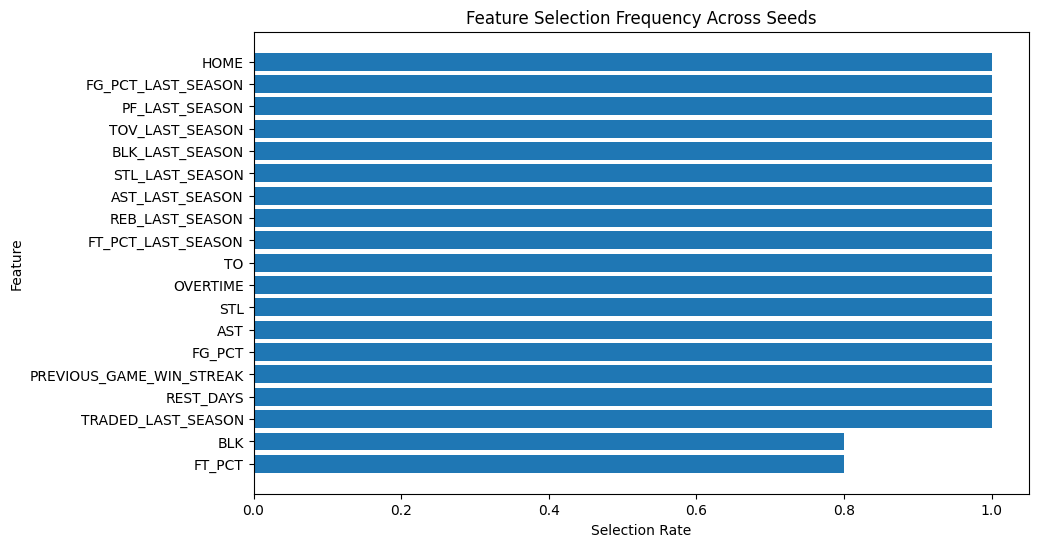

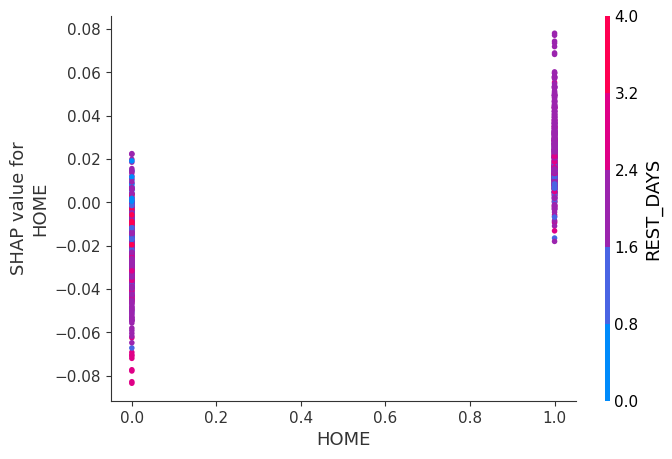

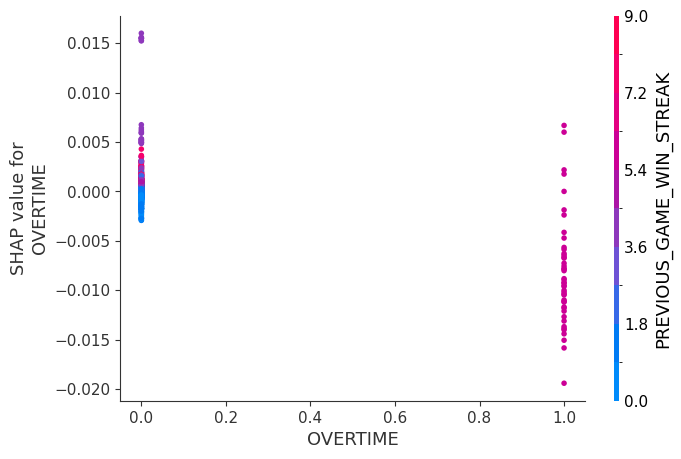

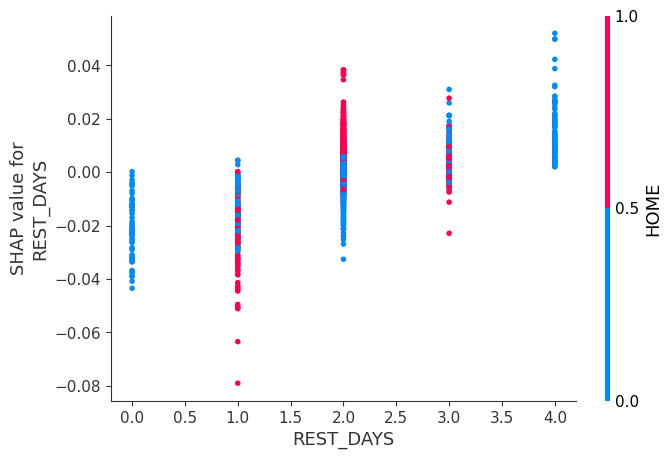

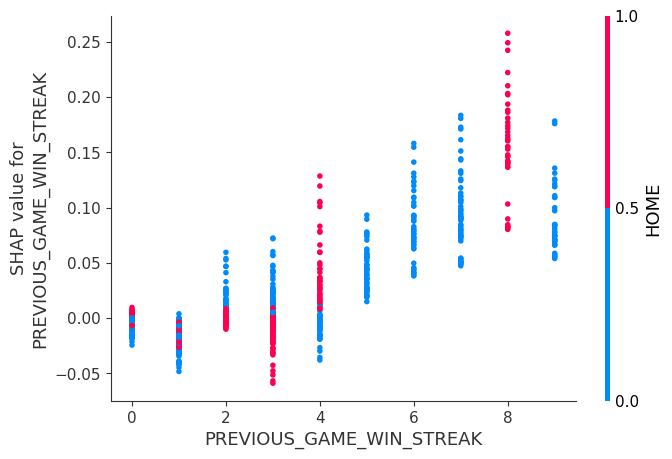

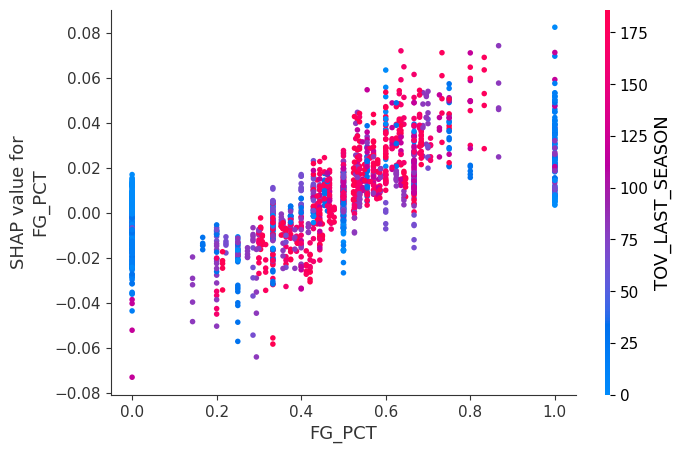

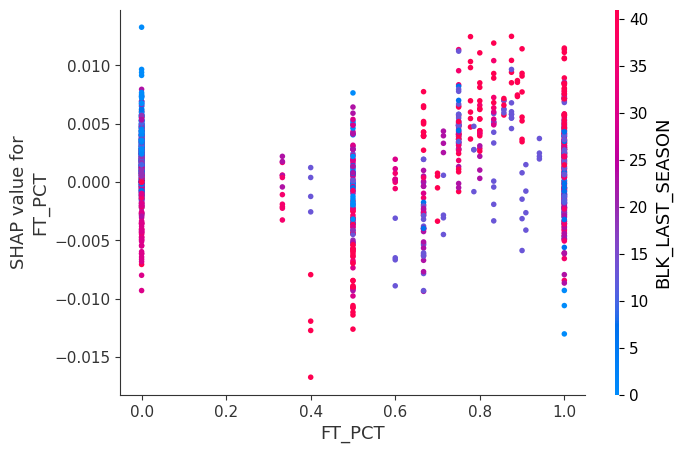

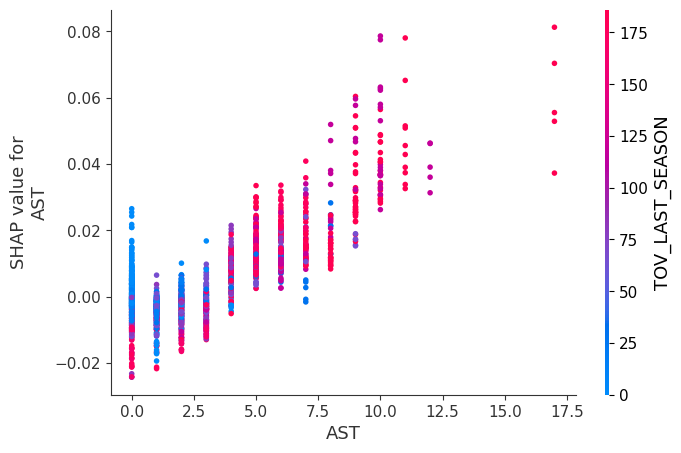

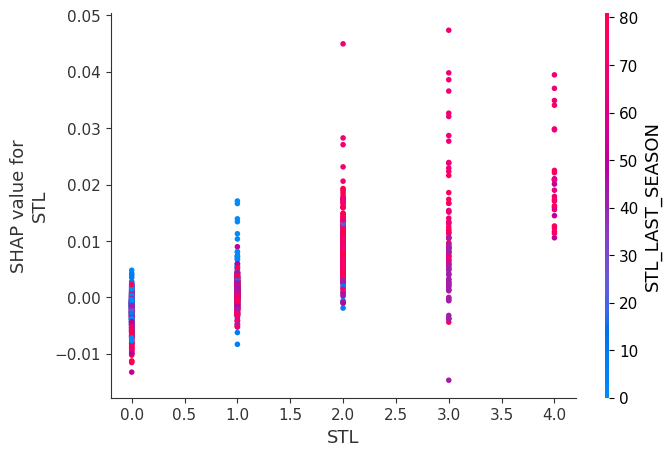

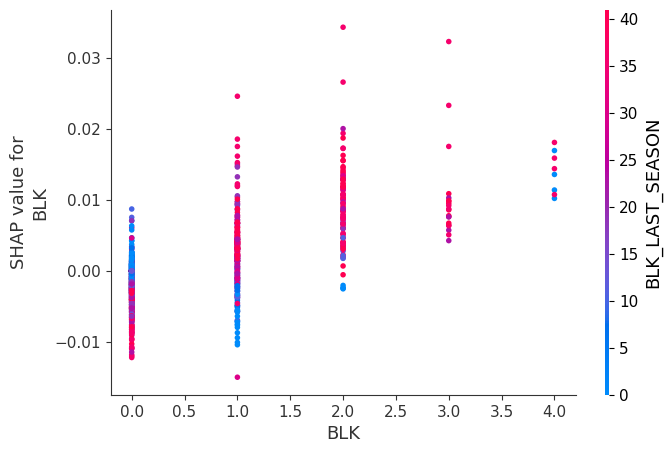

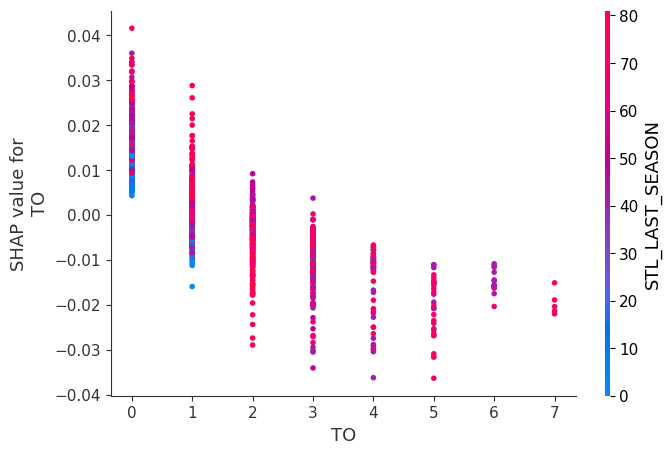

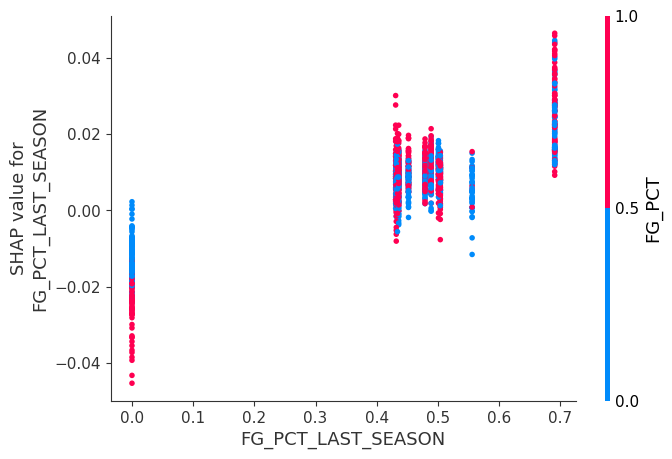

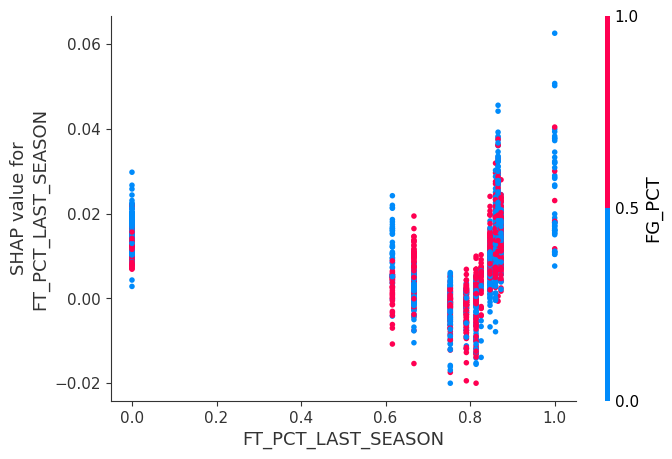

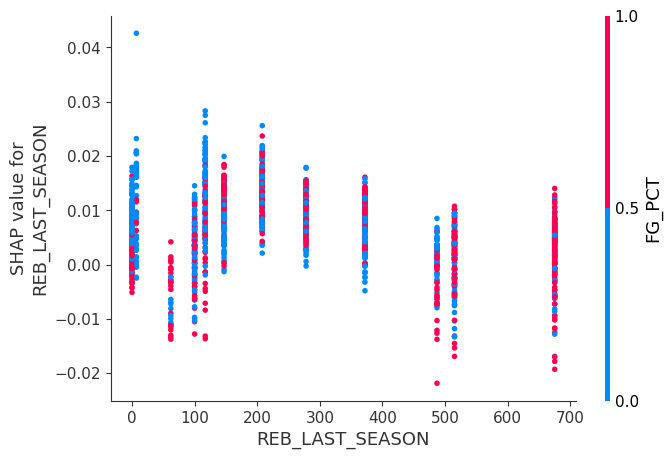

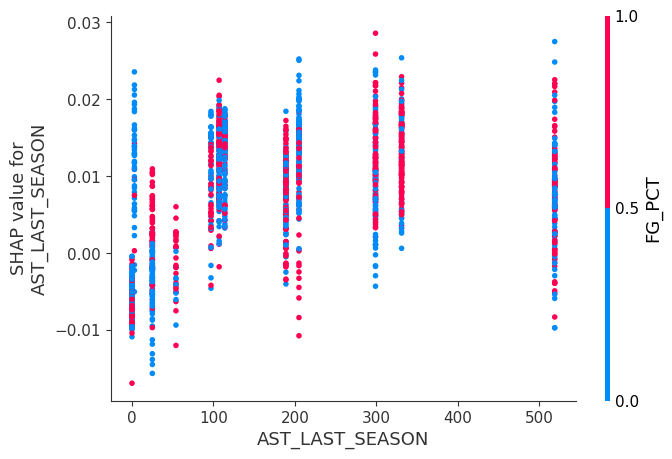

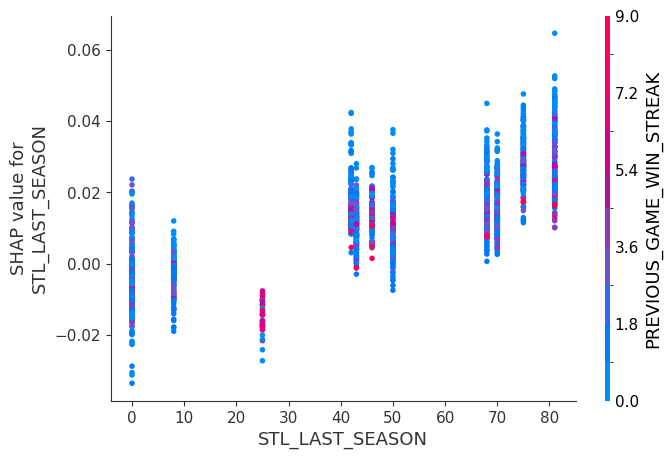

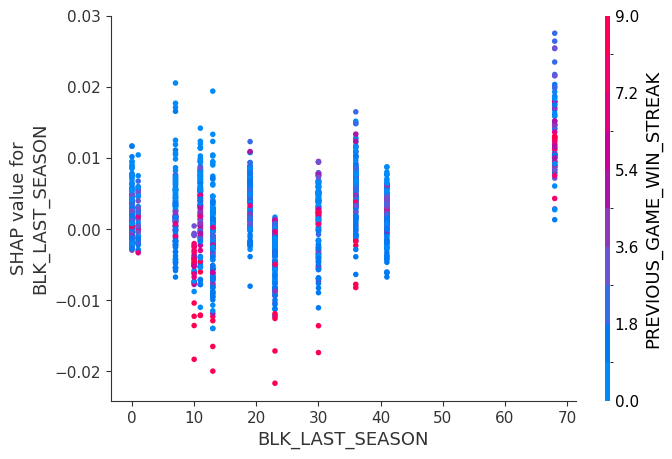

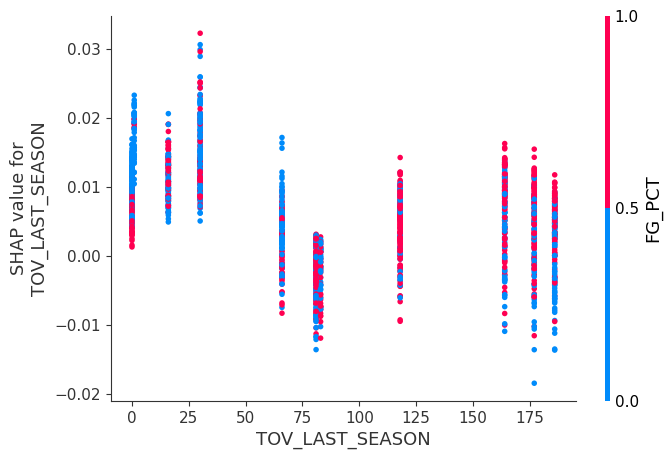

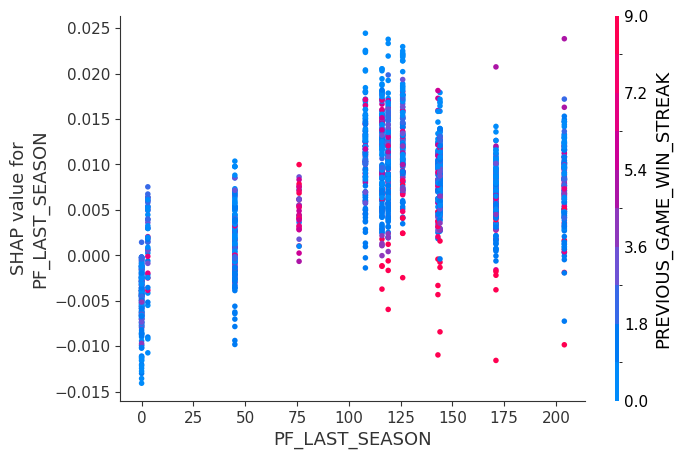

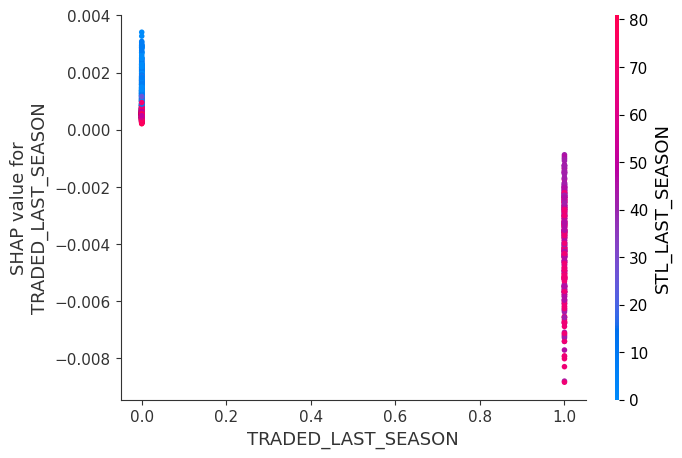

In [ ]:
# 7) Feature importance summary
feature_importance = pd.DataFrame({
    'Feature': consistent_features,
    'Mean Absolute SHAP': np.abs(combined_shap.values).mean(axis=0),
    'Selection Frequency': [
        feature_selection_counts[feature] / 5 for feat in consistent_features
    ]
}).sort_values('Mean Absolute SHAP', ascending=False)
print("\nFeature Importance:\n", feature_importance)

# 8) Stability metrics
stability_metrics = pd.DataFrame({
    'Feature': consistent_features,
    'Selection Rate': [
        feature_selection_counts[feat] / 5 for feat in consistent_features
    ]
}).sort_values('Selection Rate', ascending=False)
print("\nStability Metrics:\n", stability_metrics)

# 9) Plot feature selection frequencies
plt.figure(figsize=(10, 6))
plt.barh(stability_metrics['Feature'], stability_metrics['Selection Rate'])
plt.xlabel('Selection Rate')
plt.ylabel('Feature')
plt.title('Feature Selection Frequency Across Seeds')
plt.gca().invert_yaxis()
plt.show()

# 10) Generate dependence plots for all consistent features
for feature in consistent_features:
    shap.dependence_plot(feature, combined_shap.values, combined_features)


In [ ]:
# prompt: plot shap values for a player in the knicks team to show what impacts the prediction

# Assuming you have 'final_model', 'X_test_selected', and 'shap_values' defined as in your code.

# Function to plot SHAP values for a specific team
def plot_team_shap(team_index):
  """Plots SHAP values for a specific team.

  Args:
    team_index: The index of the team in X_test_selected.
  """

  team_shap_values = shap_values[team_index]
  team_features = X_test_selected.iloc[team_index]

  # Create a SHAP force plot for the team
  shap.force_plot(
      explainer.expected_value,
      team_shap_values,
      team_features,
      feature_names=X_test_selected.columns,
      matplotlib=True,
      show=False
  )
  plt.title(f"SHAP Values for Team {team_index}")
  plt.show()


# Example: Plot SHAP values for the 5th team in the test set
plot_team_shap(5)
